## Setup environment

In [1]:
!pip install -q "monai-weekly[nibabel, tqdm, einops]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

In [2]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
import shutil
import tempfile

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

from monai.losses import DiceCELoss
from monai.inferers import sliding_window_inference
from monai.transforms import (
    AsDiscrete,
    AddChanneld,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandFlipd,
    RandCropByPosNegLabeld,
    RandShiftIntensityd,
    ScaleIntensityRanged,
    Spacingd,
    RandRotate90d,
    ToTensord,
)

from monai.config import print_config
from monai.metrics import DiceMetric
from monai.networks.nets import UNETR

from monai.data import (
    DataLoader,
    CacheDataset,
    load_decathlon_datalist,
    decollate_batch,
)


import torch

print_config()

MONAI version: 0.9.dev2150
Numpy version: 1.21.4
Pytorch version: 1.10.1+cu113
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: 5cfb3addebf8eca5d191c4e63384c3f513221b5b

Optional dependencies:
Pytorch Ignite version: 0.4.6
Nibabel version: 3.2.1
scikit-image version: 0.19.1
Pillow version: 7.0.0
Tensorboard version: 2.7.0
gdown version: 4.2.0
TorchVision version: 0.11.2+cu113
tqdm version: 4.62.3
lmdb version: 1.2.1
psutil version: 5.5.1
pandas version: 1.3.5
einops version: 0.3.2
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



## Setup data directory

In [3]:
directory = "/home/sara/MONAI/KOMP"
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/home/sara/MONAI/KOMP


## Setup transforms for training and validation

In [4]:
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AddChanneld(keys=["image", "label"]),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1, 1, 1),
            mode=("bilinear", "nearest"),
        ),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-175,
            a_max=250,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=(96, 96, 96),
            pos=1,
            neg=1,
            num_samples=4,
            image_key="image",
            image_threshold=0,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[0],
            prob=0.10,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[1],
            prob=0.10,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[2],
            prob=0.10,
        ),
        RandRotate90d(
            keys=["image", "label"],
            prob=0.10,
            max_k=3,
        ),
        RandShiftIntensityd(
            keys=["image"],
            offsets=0.10,
            prob=0.50,
        ),
        ToTensord(keys=["image", "label"]),
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AddChanneld(keys=["image", "label"]),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1, 1, 1),
            mode=("bilinear", "nearest"),
        ),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        ScaleIntensityRanged(
            keys=["image"], a_min=-175, a_max=250, b_min=0.0, b_max=1.0, clip=True
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        ToTensord(keys=["image", "label"]),
    ]
)

In [5]:
data_dir = "./data/"
split_JSON = "dataset_0.json"
datasets = data_dir + split_JSON
datalist = load_decathlon_datalist(datasets, True, "training")
val_files = load_decathlon_datalist(datasets, True, "validation")
train_ds = CacheDataset(
    data=datalist,
    transform=train_transforms,
    cache_num=39,
    cache_rate=1.0,
    num_workers=8,
)
train_loader = DataLoader(
    train_ds, batch_size=1, shuffle=True, num_workers=8, pin_memory=True
)
val_ds = CacheDataset(
    data=val_files, transform=val_transforms, cache_num=10, cache_rate=1.0, num_workers=4
)
val_loader = DataLoader(
    val_ds, batch_size=1, shuffle=False, num_workers=4, pin_memory=True
)

Loading dataset: 100%|██████████████████████████| 10/10 [00:02<00:00,  3.55it/s]


## Check data shape and visualize

image shape: torch.Size([1, 209, 250, 400]), label shape: torch.Size([1, 209, 250, 400])


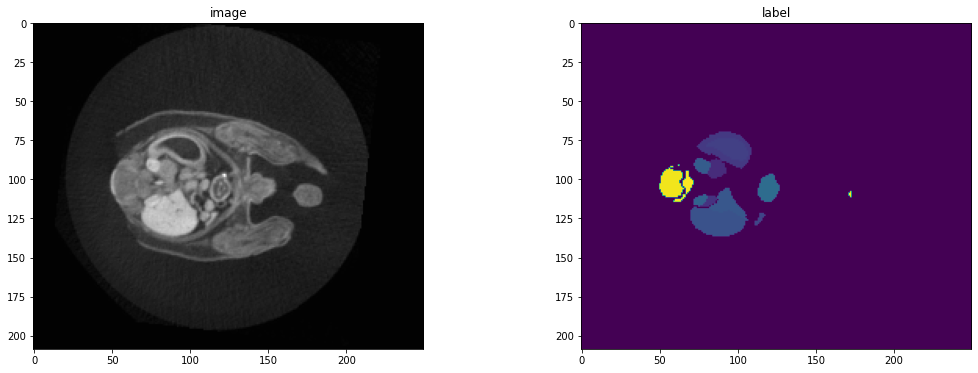

In [6]:
slice_map = {
    "AAMN_N305_10.nii.gz": 100,
    "AAMN_N305_14.nii.gz": 150,
    "AAMN_N305_15.nii.gz": 160,
    "AAMN_N305_17.nii.gz": 125,
    "AAMN_N305_23.nii.gz": 175,
    "AAMN_N305_26.nii.gz": 140,
}
case_num = 5
img_name = os.path.split(val_ds[case_num]["image_meta_dict"]["filename_or_obj"])[1]
img = val_ds[case_num]["image"]
label = val_ds[case_num]["label"]
img_shape = img.shape
label_shape = label.shape
print(f"image shape: {img_shape}, label shape: {label_shape}")
plt.figure("image", (18, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(img[0, :, :, slice_map[img_name]].detach().cpu(), cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[0, :, :, slice_map[img_name]].detach().cpu())
plt.show()

### Create Model, Loss, Optimizer


In [7]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
#os.environ["CUDA_VISIBLE_DEVICES"]="1" 
torch.set_num_threads(24)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UNETR(
    in_channels=1,
    out_channels=51,
    img_size=(96, 96, 96),
    feature_size=16,
    hidden_size=768,
    mlp_dim=3072,
    num_heads=12,
    pos_embed="perceptron",
    norm_name="instance",
    res_block=True,
    dropout_rate=0.0,
).to(device)

loss_function = DiceCELoss(to_onehot_y=True, softmax=True)
torch.backends.cudnn.benchmark = True
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)

### Execute a typical PyTorch training process

In [9]:
def validation(epoch_iterator_val):
    model.eval()
    dice_vals = list()
    with torch.no_grad():
        for step, batch in enumerate(epoch_iterator_val):
            val_inputs, val_labels = (batch["image"].cuda(), batch["label"].cuda())
            val_outputs = sliding_window_inference(val_inputs, (96, 96, 96), 4, model)
            val_labels_list = decollate_batch(val_labels)
            val_labels_convert = [
                post_label(val_label_tensor) for val_label_tensor in val_labels_list
            ]
            val_outputs_list = decollate_batch(val_outputs)
            val_output_convert = [
                post_pred(val_pred_tensor) for val_pred_tensor in val_outputs_list
            ]
            dice_metric(y_pred=val_output_convert, y=val_labels_convert)
            dice = dice_metric.aggregate().item()
            dice_vals.append(dice)
            epoch_iterator_val.set_description(
                "Validate (%d / %d Steps) (dice=%2.5f)" % (global_step, 10.0, dice)
            )
        dice_metric.reset()
    mean_dice_val = np.mean(dice_vals)
    return mean_dice_val


def train(global_step, train_loader, dice_val_best, global_step_best):
    model.train()
    epoch_loss = 0
    step = 0
    epoch_iterator = tqdm(
        train_loader, desc="Training (X / X Steps) (loss=X.X)", dynamic_ncols=True
    )
    for step, batch in enumerate(epoch_iterator):
        step += 1
        x, y = (batch["image"].cuda(), batch["label"].cuda())
        logit_map = model(x)
        loss = loss_function(logit_map, y)
        loss.backward()
        epoch_loss += loss.item()
        optimizer.step()
        optimizer.zero_grad()
        epoch_iterator.set_description(
            "Training (%d / %d Steps) (loss=%2.5f)" % (global_step, max_iterations, loss)
        )
        if (
            global_step % eval_num == 0 and global_step != 0
        ) or global_step == max_iterations:
            epoch_iterator_val = tqdm(
                val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True
            )
            dice_val = validation(epoch_iterator_val)
            epoch_loss /= step
            epoch_loss_values.append(epoch_loss)
            metric_values.append(dice_val)
            if dice_val > dice_val_best:
                dice_val_best = dice_val
                global_step_best = global_step
                torch.save(
                    model.state_dict(), os.path.join(root_dir, "best_metric_model.pth")
                )
                print(
                    "Model Was Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(
                        dice_val_best, dice_val
                    )
                )
            else:
                print(
                    "Model Was Not Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(
                        dice_val_best, dice_val
                    )
                )
        global_step += 1
    return global_step, dice_val_best, global_step_best



In [10]:
max_iterations = 50000
eval_num = 500
post_label = AsDiscrete(to_onehot=51)
post_pred = AsDiscrete(argmax=True, to_onehot=51)
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
global_step = 0
dice_val_best = 0.0
global_step_best = 0
epoch_loss_values = []
metric_values = []

In [11]:
while global_step < max_iterations:
    global_step, dice_val_best, global_step_best = train(
        global_step, train_loader, dice_val_best, global_step_best
    )
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))

Training (38 / 50000 Steps) (loss=4.35167): 100%|█| 39/39 [00:21<00:00,  1.83it/
Training (77 / 50000 Steps) (loss=4.13186): 100%|█| 39/39 [00:18<00:00,  2.08it/
Training (116 / 50000 Steps) (loss=4.01019): 100%|█| 39/39 [00:18<00:00,  2.07it
Training (155 / 50000 Steps) (loss=3.87759): 100%|█| 39/39 [00:19<00:00,  2.04it
Training (194 / 50000 Steps) (loss=3.91734): 100%|█| 39/39 [00:19<00:00,  2.03it
Training (233 / 50000 Steps) (loss=3.90019): 100%|█| 39/39 [00:19<00:00,  2.05it
Training (272 / 50000 Steps) (loss=3.57511): 100%|█| 39/39 [00:19<00:00,  2.04it
Training (311 / 50000 Steps) (loss=3.49562): 100%|█| 39/39 [00:19<00:00,  2.01it
Training (350 / 50000 Steps) (loss=3.48748): 100%|█| 39/39 [00:19<00:00,  2.02it
Training (389 / 50000 Steps) (loss=3.49924): 100%|█| 39/39 [00:19<00:00,  2.04it
Training (428 / 50000 Steps) (loss=3.43485): 100%|█| 39/39 [00:19<00:00,  2.03it
Training (467 / 50000 Steps) (loss=3.41676): 100%|█| 39/39 [00:19<00:00,  2.04it
Training (500 / 50000 Steps)

Model Was Saved ! Current Best Avg. Dice: 0.020265215449035166 Current Avg. Dice: 0.020265215449035166


Training (506 / 50000 Steps) (loss=3.15902): 100%|█| 39/39 [00:41<00:00,  1.05s/
Training (545 / 50000 Steps) (loss=3.30076): 100%|█| 39/39 [00:19<00:00,  2.03it
Training (584 / 50000 Steps) (loss=3.07675): 100%|█| 39/39 [00:19<00:00,  2.03it
Training (623 / 50000 Steps) (loss=2.87206): 100%|█| 39/39 [00:19<00:00,  2.02it
Training (662 / 50000 Steps) (loss=2.80916): 100%|█| 39/39 [00:19<00:00,  2.02it
Training (701 / 50000 Steps) (loss=2.75913): 100%|█| 39/39 [00:19<00:00,  2.02it
Training (740 / 50000 Steps) (loss=2.84655): 100%|█| 39/39 [00:19<00:00,  2.04it
Training (779 / 50000 Steps) (loss=2.82403): 100%|█| 39/39 [00:19<00:00,  2.02it
Training (818 / 50000 Steps) (loss=2.61994): 100%|█| 39/39 [00:19<00:00,  2.03it
Training (857 / 50000 Steps) (loss=2.47013): 100%|█| 39/39 [00:19<00:00,  2.01it
Training (896 / 50000 Steps) (loss=2.31985): 100%|█| 39/39 [00:19<00:00,  2.02it
Training (935 / 50000 Steps) (loss=2.38803): 100%|█| 39/39 [00:19<00:00,  2.03it
Training (974 / 50000 Steps)

Model Was Saved ! Current Best Avg. Dice: 0.02721663434058428 Current Avg. Dice: 0.02721663434058428


Training (1013 / 50000 Steps) (loss=2.20443): 100%|█| 39/39 [00:41<00:00,  1.05s
Training (1052 / 50000 Steps) (loss=2.04736): 100%|█| 39/39 [00:19<00:00,  2.02i
Training (1091 / 50000 Steps) (loss=2.29530): 100%|█| 39/39 [00:19<00:00,  2.01i
Training (1130 / 50000 Steps) (loss=2.08184): 100%|█| 39/39 [00:19<00:00,  2.03i
Training (1169 / 50000 Steps) (loss=2.26077): 100%|█| 39/39 [00:19<00:00,  2.04i
Training (1208 / 50000 Steps) (loss=1.92669): 100%|█| 39/39 [00:19<00:00,  2.03i
Training (1247 / 50000 Steps) (loss=1.95945): 100%|█| 39/39 [00:19<00:00,  2.03i
Training (1286 / 50000 Steps) (loss=2.25471): 100%|█| 39/39 [00:19<00:00,  2.02i
Training (1325 / 50000 Steps) (loss=1.94016): 100%|█| 39/39 [00:19<00:00,  2.03i
Training (1364 / 50000 Steps) (loss=1.78802): 100%|█| 39/39 [00:19<00:00,  2.01i
Training (1403 / 50000 Steps) (loss=1.79539): 100%|█| 39/39 [00:19<00:00,  2.02i
Training (1442 / 50000 Steps) (loss=1.89453): 100%|█| 39/39 [00:19<00:00,  2.02i
Training (1481 / 50000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.028697717189788818 Current Avg. Dice: 0.028697717189788818


Training (1520 / 50000 Steps) (loss=1.78516): 100%|█| 39/39 [00:40<00:00,  1.05s
Training (1559 / 50000 Steps) (loss=2.11488): 100%|█| 39/39 [00:19<00:00,  2.03i
Training (1598 / 50000 Steps) (loss=1.69800): 100%|█| 39/39 [00:19<00:00,  2.02i
Training (1637 / 50000 Steps) (loss=2.07194): 100%|█| 39/39 [00:19<00:00,  2.03i
Training (1676 / 50000 Steps) (loss=1.70474): 100%|█| 39/39 [00:19<00:00,  2.04i
Training (1715 / 50000 Steps) (loss=1.73090): 100%|█| 39/39 [00:19<00:00,  2.04i
Training (1754 / 50000 Steps) (loss=1.83128): 100%|█| 39/39 [00:19<00:00,  2.02i
Training (1793 / 50000 Steps) (loss=1.57453): 100%|█| 39/39 [00:19<00:00,  2.03i
Training (1832 / 50000 Steps) (loss=1.49537): 100%|█| 39/39 [00:19<00:00,  2.01i
Training (1871 / 50000 Steps) (loss=1.98298): 100%|█| 39/39 [00:19<00:00,  2.01i
Training (1910 / 50000 Steps) (loss=1.88796): 100%|█| 39/39 [00:19<00:00,  2.04i
Training (1949 / 50000 Steps) (loss=1.77015): 100%|█| 39/39 [00:19<00:00,  2.04i
Training (1988 / 50000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.041306884959340096 Current Avg. Dice: 0.041306884959340096


Training (2027 / 50000 Steps) (loss=1.92636): 100%|█| 39/39 [00:40<00:00,  1.05s
Training (2066 / 50000 Steps) (loss=1.63795): 100%|█| 39/39 [00:19<00:00,  2.02i
Training (2105 / 50000 Steps) (loss=1.50833): 100%|█| 39/39 [00:19<00:00,  2.03i
Training (2144 / 50000 Steps) (loss=1.52915): 100%|█| 39/39 [00:19<00:00,  2.02i
Training (2183 / 50000 Steps) (loss=1.67546): 100%|█| 39/39 [00:19<00:00,  2.03i
Training (2222 / 50000 Steps) (loss=1.67669): 100%|█| 39/39 [00:19<00:00,  2.02i
Training (2261 / 50000 Steps) (loss=1.43193): 100%|█| 39/39 [00:19<00:00,  2.04i
Training (2300 / 50000 Steps) (loss=1.58832): 100%|█| 39/39 [00:19<00:00,  2.04i
Training (2339 / 50000 Steps) (loss=1.47227): 100%|█| 39/39 [00:19<00:00,  2.03i
Training (2378 / 50000 Steps) (loss=1.38488): 100%|█| 39/39 [00:19<00:00,  2.01i
Training (2417 / 50000 Steps) (loss=1.58059): 100%|█| 39/39 [00:19<00:00,  2.01i
Training (2456 / 50000 Steps) (loss=1.62111): 100%|█| 39/39 [00:19<00:00,  2.04i
Training (2495 / 50000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.041306884959340096 Current Avg. Dice: 0.040716175362467764


Training (2534 / 50000 Steps) (loss=2.03696): 100%|█| 39/39 [00:40<00:00,  1.04s
Training (2573 / 50000 Steps) (loss=1.46699): 100%|█| 39/39 [00:19<00:00,  2.02i
Training (2612 / 50000 Steps) (loss=1.50707): 100%|█| 39/39 [00:19<00:00,  2.03i
Training (2651 / 50000 Steps) (loss=2.01881): 100%|█| 39/39 [00:19<00:00,  2.01i
Training (2690 / 50000 Steps) (loss=1.59671): 100%|█| 39/39 [00:19<00:00,  2.04i
Training (2729 / 50000 Steps) (loss=1.63617): 100%|█| 39/39 [00:19<00:00,  2.04i
Training (2768 / 50000 Steps) (loss=1.40606): 100%|█| 39/39 [00:19<00:00,  2.02i
Training (2807 / 50000 Steps) (loss=1.46178): 100%|█| 39/39 [00:19<00:00,  2.03i
Training (2846 / 50000 Steps) (loss=1.32426): 100%|█| 39/39 [00:19<00:00,  2.03i
Training (2885 / 50000 Steps) (loss=1.60728): 100%|█| 39/39 [00:19<00:00,  2.02i
Training (2924 / 50000 Steps) (loss=2.15164): 100%|█| 39/39 [00:19<00:00,  2.03i
Training (2963 / 50000 Steps) (loss=1.65818): 100%|█| 39/39 [00:19<00:00,  2.02i
Training (3000 / 50000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.04397176578640938 Current Avg. Dice: 0.04397176578640938


Training (3002 / 50000 Steps) (loss=1.45597): 100%|█| 39/39 [00:40<00:00,  1.04s
Training (3041 / 50000 Steps) (loss=1.56414): 100%|█| 39/39 [00:19<00:00,  2.01i
Training (3080 / 50000 Steps) (loss=1.58603): 100%|█| 39/39 [00:19<00:00,  2.03i
Training (3119 / 50000 Steps) (loss=1.58237): 100%|█| 39/39 [00:19<00:00,  2.02i
Training (3158 / 50000 Steps) (loss=1.25304): 100%|█| 39/39 [00:19<00:00,  2.03i
Training (3197 / 50000 Steps) (loss=1.51650): 100%|█| 39/39 [00:19<00:00,  2.02i
Training (3236 / 50000 Steps) (loss=1.86095): 100%|█| 39/39 [00:19<00:00,  2.04i
Training (3275 / 50000 Steps) (loss=1.62043): 100%|█| 39/39 [00:19<00:00,  2.01i
Training (3314 / 50000 Steps) (loss=1.68474): 100%|█| 39/39 [00:19<00:00,  2.01i
Training (3353 / 50000 Steps) (loss=1.19301): 100%|█| 39/39 [00:19<00:00,  2.02i
Training (3392 / 50000 Steps) (loss=1.95280): 100%|█| 39/39 [00:19<00:00,  2.04i
Training (3431 / 50000 Steps) (loss=1.50747): 100%|█| 39/39 [00:19<00:00,  2.02i
Training (3470 / 50000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.048851353302598 Current Avg. Dice: 0.048851353302598


Training (3509 / 50000 Steps) (loss=2.00769): 100%|█| 39/39 [00:40<00:00,  1.05s
Training (3548 / 50000 Steps) (loss=1.43451): 100%|█| 39/39 [00:19<00:00,  2.03i
Training (3587 / 50000 Steps) (loss=1.69438): 100%|█| 39/39 [00:19<00:00,  2.03i
Training (3626 / 50000 Steps) (loss=1.20002): 100%|█| 39/39 [00:19<00:00,  2.04i
Training (3665 / 50000 Steps) (loss=1.29071): 100%|█| 39/39 [00:19<00:00,  2.04i
Training (3704 / 50000 Steps) (loss=1.27699): 100%|█| 39/39 [00:19<00:00,  2.03i
Training (3743 / 50000 Steps) (loss=1.56048): 100%|█| 39/39 [00:19<00:00,  2.04i
Training (3782 / 50000 Steps) (loss=1.68671): 100%|█| 39/39 [00:19<00:00,  2.04i
Training (3821 / 50000 Steps) (loss=1.71313): 100%|█| 39/39 [00:19<00:00,  2.03i
Training (3860 / 50000 Steps) (loss=1.82342): 100%|█| 39/39 [00:19<00:00,  2.03i
Training (3899 / 50000 Steps) (loss=1.49830): 100%|█| 39/39 [00:19<00:00,  2.01i
Training (3938 / 50000 Steps) (loss=1.41412): 100%|█| 39/39 [00:19<00:00,  2.03i
Training (3977 / 50000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.05748713128268719 Current Avg. Dice: 0.05748713128268719


Training (4016 / 50000 Steps) (loss=1.53714): 100%|█| 39/39 [00:40<00:00,  1.05s
Training (4055 / 50000 Steps) (loss=1.69880): 100%|█| 39/39 [00:19<00:00,  2.02i
Training (4094 / 50000 Steps) (loss=1.64699): 100%|█| 39/39 [00:19<00:00,  2.01i
Training (4133 / 50000 Steps) (loss=1.31587): 100%|█| 39/39 [00:19<00:00,  2.03i
Training (4172 / 50000 Steps) (loss=1.62243): 100%|█| 39/39 [00:19<00:00,  2.04i
Training (4211 / 50000 Steps) (loss=1.26298): 100%|█| 39/39 [00:19<00:00,  2.02i
Training (4250 / 50000 Steps) (loss=1.52579): 100%|█| 39/39 [00:19<00:00,  2.02i
Training (4289 / 50000 Steps) (loss=1.82273): 100%|█| 39/39 [00:19<00:00,  2.02i
Training (4328 / 50000 Steps) (loss=1.37644): 100%|█| 39/39 [00:19<00:00,  2.03i
Training (4367 / 50000 Steps) (loss=1.28012): 100%|█| 39/39 [00:19<00:00,  2.02i
Training (4406 / 50000 Steps) (loss=1.31943): 100%|█| 39/39 [00:19<00:00,  2.03i
Training (4445 / 50000 Steps) (loss=1.83827): 100%|█| 39/39 [00:19<00:00,  2.02i
Training (4484 / 50000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.07965439707040786 Current Avg. Dice: 0.07965439707040786


Training (4523 / 50000 Steps) (loss=1.27122): 100%|█| 39/39 [00:40<00:00,  1.04s
Training (4562 / 50000 Steps) (loss=1.47716): 100%|█| 39/39 [00:19<00:00,  2.03i
Training (4601 / 50000 Steps) (loss=1.50850): 100%|█| 39/39 [00:19<00:00,  2.00i
Training (4640 / 50000 Steps) (loss=1.26602): 100%|█| 39/39 [00:19<00:00,  2.02i
Training (4679 / 50000 Steps) (loss=1.26974): 100%|█| 39/39 [00:19<00:00,  2.02i
Training (4718 / 50000 Steps) (loss=1.34930): 100%|█| 39/39 [00:19<00:00,  2.02i
Training (4757 / 50000 Steps) (loss=1.30295): 100%|█| 39/39 [00:19<00:00,  2.04i
Training (4796 / 50000 Steps) (loss=1.37932): 100%|█| 39/39 [00:19<00:00,  2.02i
Training (4835 / 50000 Steps) (loss=1.23830): 100%|█| 39/39 [00:19<00:00,  2.01i
Training (4874 / 50000 Steps) (loss=1.92937): 100%|█| 39/39 [00:19<00:00,  2.03i
Training (4913 / 50000 Steps) (loss=1.49573): 100%|█| 39/39 [00:19<00:00,  2.01i
Training (4952 / 50000 Steps) (loss=1.27535): 100%|█| 39/39 [00:19<00:00,  2.04i
Training (4991 / 50000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.08842883333563804 Current Avg. Dice: 0.08842883333563804


Training (5030 / 50000 Steps) (loss=1.50170): 100%|█| 39/39 [00:40<00:00,  1.05s
Training (5069 / 50000 Steps) (loss=1.50800): 100%|█| 39/39 [00:19<00:00,  2.03i
Training (5108 / 50000 Steps) (loss=1.29135): 100%|█| 39/39 [00:19<00:00,  2.03i
Training (5147 / 50000 Steps) (loss=1.46860): 100%|█| 39/39 [00:19<00:00,  2.02i
Training (5186 / 50000 Steps) (loss=1.41206): 100%|█| 39/39 [00:19<00:00,  2.01i
Training (5225 / 50000 Steps) (loss=1.33792): 100%|█| 39/39 [00:19<00:00,  2.01i
Training (5264 / 50000 Steps) (loss=1.31013): 100%|█| 39/39 [00:19<00:00,  2.02i
Training (5303 / 50000 Steps) (loss=1.29346): 100%|█| 39/39 [00:19<00:00,  2.03i
Training (5342 / 50000 Steps) (loss=1.46208): 100%|█| 39/39 [00:19<00:00,  2.03i
Training (5381 / 50000 Steps) (loss=1.33010): 100%|█| 39/39 [00:19<00:00,  2.03i
Training (5420 / 50000 Steps) (loss=1.44466): 100%|█| 39/39 [00:19<00:00,  2.01i
Training (5459 / 50000 Steps) (loss=1.49367): 100%|█| 39/39 [00:19<00:00,  2.02i
Training (5498 / 50000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.10742498710751533 Current Avg. Dice: 0.10742498710751533


Training (5537 / 50000 Steps) (loss=1.18879): 100%|█| 39/39 [00:40<00:00,  1.05s
Training (5576 / 50000 Steps) (loss=1.82229): 100%|█| 39/39 [00:19<00:00,  2.00i
Training (5615 / 50000 Steps) (loss=1.56535): 100%|█| 39/39 [00:19<00:00,  2.03i
Training (5654 / 50000 Steps) (loss=1.57118): 100%|█| 39/39 [00:19<00:00,  2.02i
Training (5693 / 50000 Steps) (loss=1.36519): 100%|█| 39/39 [00:19<00:00,  2.01i
Training (5732 / 50000 Steps) (loss=1.70609): 100%|█| 39/39 [00:19<00:00,  2.01i
Training (5771 / 50000 Steps) (loss=1.40539): 100%|█| 39/39 [00:19<00:00,  2.00i
Training (5810 / 50000 Steps) (loss=1.47021): 100%|█| 39/39 [00:19<00:00,  2.03i
Training (5849 / 50000 Steps) (loss=1.45603): 100%|█| 39/39 [00:19<00:00,  2.03i
Training (5888 / 50000 Steps) (loss=1.35882): 100%|█| 39/39 [00:19<00:00,  2.02i
Training (5927 / 50000 Steps) (loss=1.39247): 100%|█| 39/39 [00:19<00:00,  2.03i
Training (5966 / 50000 Steps) (loss=1.25546): 100%|█| 39/39 [00:19<00:00,  2.00i
Training (6000 / 50000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.11549276784062386 Current Avg. Dice: 0.11549276784062386


Training (6005 / 50000 Steps) (loss=1.28917): 100%|█| 39/39 [00:40<00:00,  1.05s
Training (6044 / 50000 Steps) (loss=1.43206): 100%|█| 39/39 [00:19<00:00,  2.01i
Training (6083 / 50000 Steps) (loss=1.32146): 100%|█| 39/39 [00:19<00:00,  2.03i
Training (6122 / 50000 Steps) (loss=1.62444): 100%|█| 39/39 [00:19<00:00,  2.00i
Training (6161 / 50000 Steps) (loss=1.46912): 100%|█| 39/39 [00:19<00:00,  2.03i
Training (6200 / 50000 Steps) (loss=1.14581): 100%|█| 39/39 [00:19<00:00,  2.01i
Training (6239 / 50000 Steps) (loss=1.42477): 100%|█| 39/39 [00:19<00:00,  2.01i
Training (6278 / 50000 Steps) (loss=1.25428): 100%|█| 39/39 [00:19<00:00,  2.02i
Training (6317 / 50000 Steps) (loss=1.32869): 100%|█| 39/39 [00:19<00:00,  2.04i
Training (6356 / 50000 Steps) (loss=1.66094): 100%|█| 39/39 [00:19<00:00,  2.00i
Training (6395 / 50000 Steps) (loss=1.49051): 100%|█| 39/39 [00:19<00:00,  2.03i
Training (6434 / 50000 Steps) (loss=1.21148): 100%|█| 39/39 [00:19<00:00,  2.02i
Training (6473 / 50000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.13372791856527327 Current Avg. Dice: 0.13372791856527327


Training (6512 / 50000 Steps) (loss=1.24055): 100%|█| 39/39 [00:41<00:00,  1.05s
Training (6551 / 50000 Steps) (loss=1.26840): 100%|█| 39/39 [00:19<00:00,  2.03i
Training (6590 / 50000 Steps) (loss=1.52535): 100%|█| 39/39 [00:19<00:00,  2.03i
Training (6629 / 50000 Steps) (loss=1.52308): 100%|█| 39/39 [00:19<00:00,  2.01i
Training (6668 / 50000 Steps) (loss=1.56421): 100%|█| 39/39 [00:19<00:00,  2.02i
Training (6707 / 50000 Steps) (loss=1.24527): 100%|█| 39/39 [00:19<00:00,  2.01i
Training (6746 / 50000 Steps) (loss=1.34326): 100%|█| 39/39 [00:19<00:00,  2.03i
Training (6785 / 50000 Steps) (loss=1.21086): 100%|█| 39/39 [00:19<00:00,  2.03i
Training (6824 / 50000 Steps) (loss=1.12877): 100%|█| 39/39 [00:19<00:00,  2.03i
Training (6863 / 50000 Steps) (loss=1.26860): 100%|█| 39/39 [00:19<00:00,  2.03i
Training (6902 / 50000 Steps) (loss=1.28420): 100%|█| 39/39 [00:19<00:00,  2.02i
Training (6941 / 50000 Steps) (loss=1.44863): 100%|█| 39/39 [00:19<00:00,  2.02i
Training (6980 / 50000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.14586158096790314 Current Avg. Dice: 0.14586158096790314


Training (7019 / 50000 Steps) (loss=1.16648): 100%|█| 39/39 [00:40<00:00,  1.05s
Training (7058 / 50000 Steps) (loss=1.23722): 100%|█| 39/39 [00:19<00:00,  2.01i
Training (7097 / 50000 Steps) (loss=1.18286): 100%|█| 39/39 [00:19<00:00,  2.00i
Training (7136 / 50000 Steps) (loss=1.37699): 100%|█| 39/39 [00:19<00:00,  2.02i
Training (7175 / 50000 Steps) (loss=1.33811): 100%|█| 39/39 [00:19<00:00,  2.03i
Training (7214 / 50000 Steps) (loss=1.32022): 100%|█| 39/39 [00:19<00:00,  2.01i
Training (7253 / 50000 Steps) (loss=1.16659): 100%|█| 39/39 [00:19<00:00,  2.01i
Training (7292 / 50000 Steps) (loss=1.34571): 100%|█| 39/39 [00:19<00:00,  2.02i
Training (7331 / 50000 Steps) (loss=1.36068): 100%|█| 39/39 [00:19<00:00,  2.03i
Training (7370 / 50000 Steps) (loss=1.27720): 100%|█| 39/39 [00:19<00:00,  2.01i
Training (7409 / 50000 Steps) (loss=1.34806): 100%|█| 39/39 [00:19<00:00,  2.02i
Training (7448 / 50000 Steps) (loss=1.16850): 100%|█| 39/39 [00:19<00:00,  2.03i
Training (7487 / 50000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.14885777831077576 Current Avg. Dice: 0.14885777831077576


Training (7526 / 50000 Steps) (loss=1.30431): 100%|█| 39/39 [00:40<00:00,  1.05s
Training (7565 / 50000 Steps) (loss=1.38318): 100%|█| 39/39 [00:19<00:00,  2.02i
Training (7604 / 50000 Steps) (loss=1.25865): 100%|█| 39/39 [00:19<00:00,  2.02i
Training (7643 / 50000 Steps) (loss=1.16013): 100%|█| 39/39 [00:19<00:00,  2.02i
Training (7682 / 50000 Steps) (loss=1.20036): 100%|█| 39/39 [00:19<00:00,  2.02i
Training (7721 / 50000 Steps) (loss=1.32985): 100%|█| 39/39 [00:19<00:00,  2.02i
Training (7760 / 50000 Steps) (loss=1.22930): 100%|█| 39/39 [00:19<00:00,  2.01i
Training (7799 / 50000 Steps) (loss=1.19741): 100%|█| 39/39 [00:19<00:00,  2.01i
Training (7838 / 50000 Steps) (loss=1.11396): 100%|█| 39/39 [00:19<00:00,  2.02i
Training (7877 / 50000 Steps) (loss=1.24736): 100%|█| 39/39 [00:19<00:00,  2.03i
Training (7916 / 50000 Steps) (loss=1.30122): 100%|█| 39/39 [00:19<00:00,  2.02i
Training (7955 / 50000 Steps) (loss=1.30560): 100%|█| 39/39 [00:19<00:00,  2.02i
Training (7994 / 50000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.15542082339525223 Current Avg. Dice: 0.15542082339525223


Training (8033 / 50000 Steps) (loss=1.17773): 100%|█| 39/39 [00:41<00:00,  1.05s
Training (8072 / 50000 Steps) (loss=1.19253): 100%|█| 39/39 [00:19<00:00,  2.02i
Training (8111 / 50000 Steps) (loss=1.30163): 100%|█| 39/39 [00:19<00:00,  2.03i
Training (8150 / 50000 Steps) (loss=1.23514): 100%|█| 39/39 [00:19<00:00,  2.04i
Training (8189 / 50000 Steps) (loss=1.19112): 100%|█| 39/39 [00:19<00:00,  2.03i
Training (8228 / 50000 Steps) (loss=1.19181): 100%|█| 39/39 [00:19<00:00,  2.03i
Training (8267 / 50000 Steps) (loss=1.27964): 100%|█| 39/39 [00:19<00:00,  2.03i
Training (8306 / 50000 Steps) (loss=1.37875): 100%|█| 39/39 [00:19<00:00,  2.04i
Training (8345 / 50000 Steps) (loss=1.33204): 100%|█| 39/39 [00:19<00:00,  2.03i
Training (8384 / 50000 Steps) (loss=1.21595): 100%|█| 39/39 [00:19<00:00,  2.02i
Training (8423 / 50000 Steps) (loss=1.38683): 100%|█| 39/39 [00:19<00:00,  2.02i
Training (8462 / 50000 Steps) (loss=1.22299): 100%|█| 39/39 [00:19<00:00,  2.03i
Training (8500 / 50000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.1710038810968399 Current Avg. Dice: 0.1710038810968399


Training (8501 / 50000 Steps) (loss=1.47023): 100%|█| 39/39 [00:40<00:00,  1.04s
Training (8540 / 50000 Steps) (loss=1.30972): 100%|█| 39/39 [00:19<00:00,  2.01i
Training (8579 / 50000 Steps) (loss=1.31577): 100%|█| 39/39 [00:19<00:00,  2.04i
Training (8618 / 50000 Steps) (loss=1.43838): 100%|█| 39/39 [00:19<00:00,  2.02i
Training (8657 / 50000 Steps) (loss=1.10639): 100%|█| 39/39 [00:19<00:00,  2.02i
Training (8696 / 50000 Steps) (loss=1.17032): 100%|█| 39/39 [00:19<00:00,  2.02i
Training (8735 / 50000 Steps) (loss=1.25349): 100%|█| 39/39 [00:19<00:00,  2.02i
Training (8774 / 50000 Steps) (loss=1.24311): 100%|█| 39/39 [00:19<00:00,  2.03i
Training (8813 / 50000 Steps) (loss=1.12576): 100%|█| 39/39 [00:19<00:00,  2.01i
Training (8852 / 50000 Steps) (loss=1.61332): 100%|█| 39/39 [00:19<00:00,  2.03i
Training (8891 / 50000 Steps) (loss=1.23142): 100%|█| 39/39 [00:19<00:00,  2.02i
Training (8930 / 50000 Steps) (loss=1.35797): 100%|█| 39/39 [00:19<00:00,  2.02i
Training (8969 / 50000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.1859125390648842 Current Avg. Dice: 0.1859125390648842


Training (9008 / 50000 Steps) (loss=1.21005): 100%|█| 39/39 [00:40<00:00,  1.04s
Training (9047 / 50000 Steps) (loss=1.12942): 100%|█| 39/39 [00:19<00:00,  2.04i
Training (9086 / 50000 Steps) (loss=1.16320): 100%|█| 39/39 [00:19<00:00,  2.02i
Training (9125 / 50000 Steps) (loss=1.28450): 100%|█| 39/39 [00:19<00:00,  2.02i
Training (9164 / 50000 Steps) (loss=1.19675): 100%|█| 39/39 [00:19<00:00,  2.01i
Training (9203 / 50000 Steps) (loss=1.27468): 100%|█| 39/39 [00:19<00:00,  2.02i
Training (9242 / 50000 Steps) (loss=1.25057): 100%|█| 39/39 [00:19<00:00,  2.01i
Training (9281 / 50000 Steps) (loss=1.28825): 100%|█| 39/39 [00:19<00:00,  2.02i
Training (9320 / 50000 Steps) (loss=1.22414): 100%|█| 39/39 [00:19<00:00,  2.02i
Training (9359 / 50000 Steps) (loss=1.30709): 100%|█| 39/39 [00:19<00:00,  2.03i
Training (9398 / 50000 Steps) (loss=1.24310): 100%|█| 39/39 [00:19<00:00,  2.04i
Training (9437 / 50000 Steps) (loss=1.31506): 100%|█| 39/39 [00:19<00:00,  2.02i
Training (9476 / 50000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.19819865971803666 Current Avg. Dice: 0.19819865971803666


Training (9515 / 50000 Steps) (loss=1.17469): 100%|█| 39/39 [00:40<00:00,  1.04s
Training (9554 / 50000 Steps) (loss=1.10922): 100%|█| 39/39 [00:19<00:00,  2.04i
Training (9593 / 50000 Steps) (loss=1.60169): 100%|█| 39/39 [00:19<00:00,  2.03i
Training (9632 / 50000 Steps) (loss=1.32234): 100%|█| 39/39 [00:19<00:00,  2.04i
Training (9671 / 50000 Steps) (loss=1.28885): 100%|█| 39/39 [00:19<00:00,  2.03i
Training (9710 / 50000 Steps) (loss=1.33681): 100%|█| 39/39 [00:19<00:00,  2.02i
Training (9749 / 50000 Steps) (loss=1.37814): 100%|█| 39/39 [00:19<00:00,  2.03i
Training (9788 / 50000 Steps) (loss=1.15905): 100%|█| 39/39 [00:19<00:00,  2.03i
Training (9827 / 50000 Steps) (loss=1.30122): 100%|█| 39/39 [00:19<00:00,  2.03i
Training (9866 / 50000 Steps) (loss=1.09532): 100%|█| 39/39 [00:19<00:00,  2.04i
Training (9905 / 50000 Steps) (loss=1.32866): 100%|█| 39/39 [00:19<00:00,  2.02i
Training (9944 / 50000 Steps) (loss=1.32706): 100%|█| 39/39 [00:19<00:00,  2.04i
Training (9983 / 50000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.2412728413939476 Current Avg. Dice: 0.2412728413939476


Training (10022 / 50000 Steps) (loss=1.28375): 100%|█| 39/39 [00:40<00:00,  1.04
Training (10061 / 50000 Steps) (loss=1.27466): 100%|█| 39/39 [00:19<00:00,  2.02
Training (10100 / 50000 Steps) (loss=1.15772): 100%|█| 39/39 [00:19<00:00,  2.00
Training (10139 / 50000 Steps) (loss=1.19994): 100%|█| 39/39 [00:19<00:00,  2.03
Training (10178 / 50000 Steps) (loss=1.16842): 100%|█| 39/39 [00:19<00:00,  2.01
Training (10217 / 50000 Steps) (loss=1.20913): 100%|█| 39/39 [00:19<00:00,  2.03
Training (10256 / 50000 Steps) (loss=1.16217): 100%|█| 39/39 [00:19<00:00,  2.03
Training (10295 / 50000 Steps) (loss=1.10364): 100%|█| 39/39 [00:19<00:00,  2.02
Training (10334 / 50000 Steps) (loss=1.14503): 100%|█| 39/39 [00:19<00:00,  2.04
Training (10373 / 50000 Steps) (loss=1.14061): 100%|█| 39/39 [00:19<00:00,  2.04
Training (10412 / 50000 Steps) (loss=1.16864): 100%|█| 39/39 [00:19<00:00,  2.02
Training (10451 / 50000 Steps) (loss=1.03868): 100%|█| 39/39 [00:19<00:00,  2.02
Training (10490 / 50000 Step

Model Was Saved ! Current Best Avg. Dice: 0.25885817110538484 Current Avg. Dice: 0.25885817110538484


Training (10529 / 50000 Steps) (loss=1.30713): 100%|█| 39/39 [00:40<00:00,  1.05
Training (10568 / 50000 Steps) (loss=1.24021): 100%|█| 39/39 [00:19<00:00,  2.03
Training (10607 / 50000 Steps) (loss=1.11756): 100%|█| 39/39 [00:19<00:00,  2.04
Training (10646 / 50000 Steps) (loss=1.22542): 100%|█| 39/39 [00:19<00:00,  2.02
Training (10685 / 50000 Steps) (loss=1.23432): 100%|█| 39/39 [00:19<00:00,  2.04
Training (10724 / 50000 Steps) (loss=1.17946): 100%|█| 39/39 [00:19<00:00,  2.04
Training (10763 / 50000 Steps) (loss=1.21854): 100%|█| 39/39 [00:19<00:00,  2.04
Training (10802 / 50000 Steps) (loss=1.24918): 100%|█| 39/39 [00:19<00:00,  2.04
Training (10841 / 50000 Steps) (loss=1.07513): 100%|█| 39/39 [00:19<00:00,  2.02
Training (10880 / 50000 Steps) (loss=1.11650): 100%|█| 39/39 [00:19<00:00,  2.02
Training (10919 / 50000 Steps) (loss=1.01993): 100%|█| 39/39 [00:19<00:00,  2.03
Training (10958 / 50000 Steps) (loss=1.23192): 100%|█| 39/39 [00:19<00:00,  2.04
Training (10997 / 50000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.25885817110538484 Current Avg. Dice: 0.24702307283878328


Training (11036 / 50000 Steps) (loss=1.29926): 100%|█| 39/39 [00:40<00:00,  1.04
Training (11075 / 50000 Steps) (loss=1.21165): 100%|█| 39/39 [00:19<00:00,  2.02
Training (11114 / 50000 Steps) (loss=1.22867): 100%|█| 39/39 [00:19<00:00,  2.02
Training (11153 / 50000 Steps) (loss=1.22185): 100%|█| 39/39 [00:19<00:00,  2.02
Training (11192 / 50000 Steps) (loss=1.01969): 100%|█| 39/39 [00:19<00:00,  2.02
Training (11231 / 50000 Steps) (loss=1.06540): 100%|█| 39/39 [00:19<00:00,  2.01
Training (11270 / 50000 Steps) (loss=1.17373): 100%|█| 39/39 [00:19<00:00,  2.04
Training (11309 / 50000 Steps) (loss=1.25970): 100%|█| 39/39 [00:19<00:00,  2.03
Training (11348 / 50000 Steps) (loss=1.21535): 100%|█| 39/39 [00:19<00:00,  2.02
Training (11387 / 50000 Steps) (loss=2.06834): 100%|█| 39/39 [00:19<00:00,  2.02
Training (11426 / 50000 Steps) (loss=1.17332): 100%|█| 39/39 [00:19<00:00,  2.03
Training (11465 / 50000 Steps) (loss=1.18819): 100%|█| 39/39 [00:19<00:00,  2.02
Training (11500 / 50000 Step

Model Was Saved ! Current Best Avg. Dice: 0.28053916394710543 Current Avg. Dice: 0.28053916394710543


Training (11504 / 50000 Steps) (loss=1.15064): 100%|█| 39/39 [00:40<00:00,  1.05
Training (11543 / 50000 Steps) (loss=1.15449): 100%|█| 39/39 [00:19<00:00,  2.01
Training (11582 / 50000 Steps) (loss=1.20470): 100%|█| 39/39 [00:19<00:00,  2.01
Training (11621 / 50000 Steps) (loss=1.08125): 100%|█| 39/39 [00:19<00:00,  2.02
Training (11660 / 50000 Steps) (loss=1.23246): 100%|█| 39/39 [00:19<00:00,  2.03
Training (11699 / 50000 Steps) (loss=1.19646): 100%|█| 39/39 [00:19<00:00,  2.02
Training (11738 / 50000 Steps) (loss=1.21575): 100%|█| 39/39 [00:19<00:00,  2.04
Training (11777 / 50000 Steps) (loss=1.07528): 100%|█| 39/39 [00:19<00:00,  2.01
Training (11816 / 50000 Steps) (loss=1.15286): 100%|█| 39/39 [00:19<00:00,  2.04
Training (11855 / 50000 Steps) (loss=1.11071): 100%|█| 39/39 [00:19<00:00,  2.03
Training (11894 / 50000 Steps) (loss=1.21577): 100%|█| 39/39 [00:19<00:00,  2.01
Training (11933 / 50000 Steps) (loss=1.17178): 100%|█| 39/39 [00:19<00:00,  2.03
Training (11972 / 50000 Step

Model Was Saved ! Current Best Avg. Dice: 0.2869118243455887 Current Avg. Dice: 0.2869118243455887


Training (12011 / 50000 Steps) (loss=1.10802): 100%|█| 39/39 [00:41<00:00,  1.05
Training (12050 / 50000 Steps) (loss=1.18314): 100%|█| 39/39 [00:19<00:00,  2.02
Training (12089 / 50000 Steps) (loss=1.17943): 100%|█| 39/39 [00:19<00:00,  2.02
Training (12128 / 50000 Steps) (loss=1.22347): 100%|█| 39/39 [00:19<00:00,  2.02
Training (12167 / 50000 Steps) (loss=1.09456): 100%|█| 39/39 [00:19<00:00,  2.03
Training (12206 / 50000 Steps) (loss=1.40752): 100%|█| 39/39 [00:19<00:00,  2.04
Training (12245 / 50000 Steps) (loss=1.16056): 100%|█| 39/39 [00:19<00:00,  2.02
Training (12284 / 50000 Steps) (loss=1.23915): 100%|█| 39/39 [00:19<00:00,  2.02
Training (12323 / 50000 Steps) (loss=1.11201): 100%|█| 39/39 [00:19<00:00,  2.03
Training (12362 / 50000 Steps) (loss=1.06027): 100%|█| 39/39 [00:19<00:00,  2.03
Training (12401 / 50000 Steps) (loss=1.25231): 100%|█| 39/39 [00:19<00:00,  2.01
Training (12440 / 50000 Steps) (loss=1.42040): 100%|█| 39/39 [00:19<00:00,  2.04
Training (12479 / 50000 Step

Model Was Saved ! Current Best Avg. Dice: 0.301087412238121 Current Avg. Dice: 0.301087412238121


Training (12518 / 50000 Steps) (loss=1.03786): 100%|█| 39/39 [00:40<00:00,  1.05
Training (12557 / 50000 Steps) (loss=1.07242): 100%|█| 39/39 [00:19<00:00,  2.02
Training (12596 / 50000 Steps) (loss=2.09591): 100%|█| 39/39 [00:19<00:00,  2.02
Training (12635 / 50000 Steps) (loss=1.19591): 100%|█| 39/39 [00:19<00:00,  2.03
Training (12674 / 50000 Steps) (loss=1.02078): 100%|█| 39/39 [00:19<00:00,  2.04
Training (12713 / 50000 Steps) (loss=1.05287): 100%|█| 39/39 [00:19<00:00,  2.03
Training (12752 / 50000 Steps) (loss=1.18787): 100%|█| 39/39 [00:19<00:00,  2.02
Training (12791 / 50000 Steps) (loss=1.04240): 100%|█| 39/39 [00:19<00:00,  2.04
Training (12830 / 50000 Steps) (loss=1.21151): 100%|█| 39/39 [00:19<00:00,  2.04
Training (12869 / 50000 Steps) (loss=1.14682): 100%|█| 39/39 [00:19<00:00,  2.04
Training (12908 / 50000 Steps) (loss=1.16124): 100%|█| 39/39 [00:19<00:00,  2.00
Training (12947 / 50000 Steps) (loss=1.08933): 100%|█| 39/39 [00:19<00:00,  2.04
Training (12986 / 50000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.301087412238121 Current Avg. Dice: 0.2964329719543457


Training (13025 / 50000 Steps) (loss=1.15985): 100%|█| 39/39 [00:40<00:00,  1.03
Training (13064 / 50000 Steps) (loss=1.06869): 100%|█| 39/39 [00:19<00:00,  2.01
Training (13103 / 50000 Steps) (loss=1.08970): 100%|█| 39/39 [00:19<00:00,  2.03
Training (13142 / 50000 Steps) (loss=1.18500): 100%|█| 39/39 [00:19<00:00,  2.04
Training (13181 / 50000 Steps) (loss=1.10511): 100%|█| 39/39 [00:19<00:00,  2.04
Training (13220 / 50000 Steps) (loss=1.14512): 100%|█| 39/39 [00:19<00:00,  2.02
Training (13259 / 50000 Steps) (loss=1.33612): 100%|█| 39/39 [00:19<00:00,  2.02
Training (13298 / 50000 Steps) (loss=1.00397): 100%|█| 39/39 [00:19<00:00,  2.04
Training (13337 / 50000 Steps) (loss=1.09248): 100%|█| 39/39 [00:19<00:00,  2.02
Training (13376 / 50000 Steps) (loss=1.15740): 100%|█| 39/39 [00:19<00:00,  2.03
Training (13415 / 50000 Steps) (loss=1.07047): 100%|█| 39/39 [00:19<00:00,  2.02
Training (13454 / 50000 Steps) (loss=1.04130): 100%|█| 39/39 [00:19<00:00,  2.03
Training (13493 / 50000 Step

Model Was Saved ! Current Best Avg. Dice: 0.3402981966733932 Current Avg. Dice: 0.3402981966733932


Training (13532 / 50000 Steps) (loss=1.16076): 100%|█| 39/39 [00:40<00:00,  1.04
Training (13571 / 50000 Steps) (loss=1.25117): 100%|█| 39/39 [00:19<00:00,  2.03
Training (13610 / 50000 Steps) (loss=1.15934): 100%|█| 39/39 [00:19<00:00,  2.02
Training (13649 / 50000 Steps) (loss=1.10239): 100%|█| 39/39 [00:19<00:00,  2.04
Training (13688 / 50000 Steps) (loss=1.09434): 100%|█| 39/39 [00:19<00:00,  2.03
Training (13727 / 50000 Steps) (loss=1.11715): 100%|█| 39/39 [00:19<00:00,  2.04
Training (13766 / 50000 Steps) (loss=1.17459): 100%|█| 39/39 [00:19<00:00,  2.02
Training (13805 / 50000 Steps) (loss=1.13047): 100%|█| 39/39 [00:19<00:00,  2.02
Training (13844 / 50000 Steps) (loss=1.21774): 100%|█| 39/39 [00:19<00:00,  2.03
Training (13883 / 50000 Steps) (loss=1.10793): 100%|█| 39/39 [00:19<00:00,  2.03
Training (13922 / 50000 Steps) (loss=0.98973): 100%|█| 39/39 [00:19<00:00,  2.03
Training (13961 / 50000 Steps) (loss=1.13157): 100%|█| 39/39 [00:19<00:00,  2.04
Training (14000 / 50000 Step

Model Was Saved ! Current Best Avg. Dice: 0.3606788575649261 Current Avg. Dice: 0.3606788575649261


Training (14039 / 50000 Steps) (loss=1.16715): 100%|█| 39/39 [00:19<00:00,  2.01
Training (14078 / 50000 Steps) (loss=1.13882): 100%|█| 39/39 [00:19<00:00,  2.02
Training (14117 / 50000 Steps) (loss=1.05590): 100%|█| 39/39 [00:19<00:00,  2.02
Training (14156 / 50000 Steps) (loss=1.02499): 100%|█| 39/39 [00:19<00:00,  2.01
Training (14195 / 50000 Steps) (loss=1.03849): 100%|█| 39/39 [00:19<00:00,  2.01
Training (14234 / 50000 Steps) (loss=1.09279): 100%|█| 39/39 [00:19<00:00,  2.04
Training (14273 / 50000 Steps) (loss=1.07436): 100%|█| 39/39 [00:19<00:00,  2.02
Training (14312 / 50000 Steps) (loss=1.17147): 100%|█| 39/39 [00:19<00:00,  2.05
Training (14351 / 50000 Steps) (loss=1.11407): 100%|█| 39/39 [00:19<00:00,  2.03
Training (14390 / 50000 Steps) (loss=1.05987): 100%|█| 39/39 [00:19<00:00,  2.01
Training (14429 / 50000 Steps) (loss=1.02889): 100%|█| 39/39 [00:19<00:00,  2.04
Training (14468 / 50000 Steps) (loss=1.08125): 100%|█| 39/39 [00:19<00:00,  2.02
Training (14500 / 50000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.3606788575649261 Current Avg. Dice: 0.35483808219432833


Training (14507 / 50000 Steps) (loss=1.05674): 100%|█| 39/39 [00:40<00:00,  1.03
Training (14546 / 50000 Steps) (loss=1.01789): 100%|█| 39/39 [00:19<00:00,  2.01
Training (14585 / 50000 Steps) (loss=1.06935): 100%|█| 39/39 [00:19<00:00,  2.02
Training (14624 / 50000 Steps) (loss=1.26840): 100%|█| 39/39 [00:19<00:00,  2.04
Training (14663 / 50000 Steps) (loss=1.08842): 100%|█| 39/39 [00:19<00:00,  2.04
Training (14702 / 50000 Steps) (loss=1.05659): 100%|█| 39/39 [00:19<00:00,  2.04
Training (14741 / 50000 Steps) (loss=1.01398): 100%|█| 39/39 [00:19<00:00,  2.02
Training (14780 / 50000 Steps) (loss=1.15006): 100%|█| 39/39 [00:19<00:00,  2.03
Training (14819 / 50000 Steps) (loss=1.14485): 100%|█| 39/39 [00:19<00:00,  2.02
Training (14858 / 50000 Steps) (loss=1.10061): 100%|█| 39/39 [00:19<00:00,  2.04
Training (14897 / 50000 Steps) (loss=1.14246): 100%|█| 39/39 [00:19<00:00,  2.02
Training (14936 / 50000 Steps) (loss=1.03447): 100%|█| 39/39 [00:19<00:00,  2.02
Training (14975 / 50000 Step

Model Was Saved ! Current Best Avg. Dice: 0.39393164217472076 Current Avg. Dice: 0.39393164217472076


Training (15014 / 50000 Steps) (loss=1.04783): 100%|█| 39/39 [00:40<00:00,  1.04
Training (15053 / 50000 Steps) (loss=0.99816): 100%|█| 39/39 [00:19<00:00,  2.01
Training (15092 / 50000 Steps) (loss=2.08158): 100%|█| 39/39 [00:19<00:00,  2.04
Training (15131 / 50000 Steps) (loss=1.09165): 100%|█| 39/39 [00:19<00:00,  2.02
Training (15170 / 50000 Steps) (loss=1.13347): 100%|█| 39/39 [00:19<00:00,  2.02
Training (15209 / 50000 Steps) (loss=1.12932): 100%|█| 39/39 [00:19<00:00,  2.04
Training (15248 / 50000 Steps) (loss=1.02908): 100%|█| 39/39 [00:19<00:00,  2.03
Training (15287 / 50000 Steps) (loss=1.02499): 100%|█| 39/39 [00:19<00:00,  2.03
Training (15326 / 50000 Steps) (loss=1.09904): 100%|█| 39/39 [00:19<00:00,  2.02
Training (15365 / 50000 Steps) (loss=1.23206): 100%|█| 39/39 [00:19<00:00,  2.04
Training (15404 / 50000 Steps) (loss=1.05582): 100%|█| 39/39 [00:19<00:00,  2.03
Training (15443 / 50000 Steps) (loss=1.11266): 100%|█| 39/39 [00:19<00:00,  2.04
Training (15482 / 50000 Step

Model Was Saved ! Current Best Avg. Dice: 0.40179988741874695 Current Avg. Dice: 0.40179988741874695


Training (15521 / 50000 Steps) (loss=1.11192): 100%|█| 39/39 [00:40<00:00,  1.04
Training (15560 / 50000 Steps) (loss=1.10636): 100%|█| 39/39 [00:19<00:00,  2.03
Training (15599 / 50000 Steps) (loss=1.03752): 100%|█| 39/39 [00:19<00:00,  2.03
Training (15638 / 50000 Steps) (loss=1.07472): 100%|█| 39/39 [00:19<00:00,  2.01
Training (15677 / 50000 Steps) (loss=0.99415): 100%|█| 39/39 [00:19<00:00,  2.03
Training (15716 / 50000 Steps) (loss=1.08069): 100%|█| 39/39 [00:19<00:00,  2.02
Training (15755 / 50000 Steps) (loss=1.06513): 100%|█| 39/39 [00:19<00:00,  2.03
Training (15794 / 50000 Steps) (loss=1.02629): 100%|█| 39/39 [00:19<00:00,  2.02
Training (15833 / 50000 Steps) (loss=1.07017): 100%|█| 39/39 [00:19<00:00,  2.03
Training (15872 / 50000 Steps) (loss=1.10822): 100%|█| 39/39 [00:19<00:00,  2.03
Training (15911 / 50000 Steps) (loss=1.04516): 100%|█| 39/39 [00:19<00:00,  2.01
Training (15950 / 50000 Steps) (loss=1.12435): 100%|█| 39/39 [00:19<00:00,  2.04
Training (15989 / 50000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.40179988741874695 Current Avg. Dice: 0.40115800499916077


Training (16028 / 50000 Steps) (loss=1.05703): 100%|█| 39/39 [00:40<00:00,  1.03
Training (16067 / 50000 Steps) (loss=1.07234): 100%|█| 39/39 [00:19<00:00,  2.01
Training (16106 / 50000 Steps) (loss=1.12360): 100%|█| 39/39 [00:19<00:00,  2.03
Training (16145 / 50000 Steps) (loss=1.13885): 100%|█| 39/39 [00:19<00:00,  2.02
Training (16184 / 50000 Steps) (loss=1.09573): 100%|█| 39/39 [00:19<00:00,  2.03
Training (16223 / 50000 Steps) (loss=1.09111): 100%|█| 39/39 [00:19<00:00,  2.03
Training (16262 / 50000 Steps) (loss=1.07593): 100%|█| 39/39 [00:19<00:00,  2.03
Training (16301 / 50000 Steps) (loss=1.02666): 100%|█| 39/39 [00:19<00:00,  2.04
Training (16340 / 50000 Steps) (loss=1.06070): 100%|█| 39/39 [00:19<00:00,  2.02
Training (16379 / 50000 Steps) (loss=1.01442): 100%|█| 39/39 [00:19<00:00,  2.03
Training (16418 / 50000 Steps) (loss=0.99505): 100%|█| 39/39 [00:19<00:00,  2.03
Training (16457 / 50000 Steps) (loss=1.07945): 100%|█| 39/39 [00:19<00:00,  2.03
Training (16496 / 50000 Step

Model Was Saved ! Current Best Avg. Dice: 0.4167220801115036 Current Avg. Dice: 0.4167220801115036


Training (16535 / 50000 Steps) (loss=0.99512): 100%|█| 39/39 [00:40<00:00,  1.05
Training (16574 / 50000 Steps) (loss=1.08646): 100%|█| 39/39 [00:19<00:00,  2.04
Training (16613 / 50000 Steps) (loss=1.11016): 100%|█| 39/39 [00:19<00:00,  2.02
Training (16652 / 50000 Steps) (loss=1.02610): 100%|█| 39/39 [00:19<00:00,  2.04
Training (16691 / 50000 Steps) (loss=1.15581): 100%|█| 39/39 [00:19<00:00,  2.03
Training (16730 / 50000 Steps) (loss=1.18028): 100%|█| 39/39 [00:19<00:00,  2.04
Training (16769 / 50000 Steps) (loss=1.00505): 100%|█| 39/39 [00:19<00:00,  2.03
Training (16808 / 50000 Steps) (loss=1.11310): 100%|█| 39/39 [00:19<00:00,  2.01
Training (16847 / 50000 Steps) (loss=1.03780): 100%|█| 39/39 [00:19<00:00,  2.03
Training (16886 / 50000 Steps) (loss=1.04057): 100%|█| 39/39 [00:19<00:00,  2.03
Training (16925 / 50000 Steps) (loss=1.08072): 100%|█| 39/39 [00:19<00:00,  2.01
Training (16964 / 50000 Steps) (loss=1.04513): 100%|█| 39/39 [00:19<00:00,  2.02
Training (17000 / 50000 Step

Model Was Saved ! Current Best Avg. Dice: 0.4175399750471115 Current Avg. Dice: 0.4175399750471115


Training (17003 / 50000 Steps) (loss=1.09089): 100%|█| 39/39 [00:40<00:00,  1.05
Training (17042 / 50000 Steps) (loss=1.13677): 100%|█| 39/39 [00:19<00:00,  2.03
Training (17081 / 50000 Steps) (loss=1.07857): 100%|█| 39/39 [00:19<00:00,  2.02
Training (17120 / 50000 Steps) (loss=1.08831): 100%|█| 39/39 [00:19<00:00,  2.03
Training (17159 / 50000 Steps) (loss=1.09113): 100%|█| 39/39 [00:19<00:00,  2.01
Training (17198 / 50000 Steps) (loss=1.08003): 100%|█| 39/39 [00:19<00:00,  2.04
Training (17237 / 50000 Steps) (loss=1.06727): 100%|█| 39/39 [00:19<00:00,  2.03
Training (17276 / 50000 Steps) (loss=1.08622): 100%|█| 39/39 [00:19<00:00,  2.02
Training (17315 / 50000 Steps) (loss=1.11876): 100%|█| 39/39 [00:19<00:00,  2.04
Training (17354 / 50000 Steps) (loss=1.08539): 100%|█| 39/39 [00:19<00:00,  2.03
Training (17393 / 50000 Steps) (loss=1.00539): 100%|█| 39/39 [00:19<00:00,  2.04
Training (17432 / 50000 Steps) (loss=1.15155): 100%|█| 39/39 [00:19<00:00,  2.04
Training (17471 / 50000 Step

Model Was Saved ! Current Best Avg. Dice: 0.42973096668720245 Current Avg. Dice: 0.42973096668720245


Training (17510 / 50000 Steps) (loss=0.97841): 100%|█| 39/39 [00:40<00:00,  1.04
Training (17549 / 50000 Steps) (loss=1.14754): 100%|█| 39/39 [00:19<00:00,  2.02
Training (17588 / 50000 Steps) (loss=1.10707): 100%|█| 39/39 [00:19<00:00,  2.03
Training (17627 / 50000 Steps) (loss=1.90345): 100%|█| 39/39 [00:19<00:00,  2.03
Training (17666 / 50000 Steps) (loss=1.07282): 100%|█| 39/39 [00:19<00:00,  2.04
Training (17705 / 50000 Steps) (loss=0.99479): 100%|█| 39/39 [00:19<00:00,  2.04
Training (17744 / 50000 Steps) (loss=1.06571): 100%|█| 39/39 [00:19<00:00,  2.02
Training (17783 / 50000 Steps) (loss=1.13206): 100%|█| 39/39 [00:19<00:00,  2.02
Training (17822 / 50000 Steps) (loss=1.10018): 100%|█| 39/39 [00:19<00:00,  2.03
Training (17861 / 50000 Steps) (loss=1.10574): 100%|█| 39/39 [00:19<00:00,  2.02
Training (17900 / 50000 Steps) (loss=0.98099): 100%|█| 39/39 [00:19<00:00,  2.04
Training (17939 / 50000 Steps) (loss=1.09683): 100%|█| 39/39 [00:19<00:00,  2.00
Training (17978 / 50000 Step

Model Was Saved ! Current Best Avg. Dice: 0.43138431906700136 Current Avg. Dice: 0.43138431906700136


Training (18017 / 50000 Steps) (loss=1.15857): 100%|█| 39/39 [00:40<00:00,  1.04
Training (18056 / 50000 Steps) (loss=1.02644): 100%|█| 39/39 [00:19<00:00,  2.02
Training (18095 / 50000 Steps) (loss=0.98711): 100%|█| 39/39 [00:19<00:00,  2.03
Training (18134 / 50000 Steps) (loss=1.02631): 100%|█| 39/39 [00:19<00:00,  2.03
Training (18173 / 50000 Steps) (loss=1.02861): 100%|█| 39/39 [00:19<00:00,  2.03
Training (18212 / 50000 Steps) (loss=1.04360): 100%|█| 39/39 [00:19<00:00,  2.04
Training (18251 / 50000 Steps) (loss=1.14412): 100%|█| 39/39 [00:19<00:00,  2.03
Training (18290 / 50000 Steps) (loss=0.97575): 100%|█| 39/39 [00:19<00:00,  2.03
Training (18329 / 50000 Steps) (loss=1.14442): 100%|█| 39/39 [00:19<00:00,  2.02
Training (18368 / 50000 Steps) (loss=1.02140): 100%|█| 39/39 [00:19<00:00,  2.03
Training (18407 / 50000 Steps) (loss=1.15105): 100%|█| 39/39 [00:19<00:00,  2.02
Training (18446 / 50000 Steps) (loss=1.12359): 100%|█| 39/39 [00:19<00:00,  2.04
Training (18485 / 50000 Step

Model Was Saved ! Current Best Avg. Dice: 0.43893514275550843 Current Avg. Dice: 0.43893514275550843


Training (18524 / 50000 Steps) (loss=1.05812): 100%|█| 39/39 [00:40<00:00,  1.04
Training (18563 / 50000 Steps) (loss=1.16959): 100%|█| 39/39 [00:19<00:00,  2.04
Training (18602 / 50000 Steps) (loss=1.11936): 100%|█| 39/39 [00:19<00:00,  2.02
Training (18641 / 50000 Steps) (loss=1.05574): 100%|█| 39/39 [00:19<00:00,  2.04
Training (18680 / 50000 Steps) (loss=1.10465): 100%|█| 39/39 [00:19<00:00,  2.03
Training (18719 / 50000 Steps) (loss=0.96910): 100%|█| 39/39 [00:19<00:00,  2.02
Training (18758 / 50000 Steps) (loss=1.18481): 100%|█| 39/39 [00:19<00:00,  2.04
Training (18797 / 50000 Steps) (loss=1.08569): 100%|█| 39/39 [00:19<00:00,  2.04
Training (18836 / 50000 Steps) (loss=1.01516): 100%|█| 39/39 [00:19<00:00,  2.04
Training (18875 / 50000 Steps) (loss=1.01168): 100%|█| 39/39 [00:19<00:00,  2.02
Training (18914 / 50000 Steps) (loss=0.95870): 100%|█| 39/39 [00:19<00:00,  2.04
Training (18953 / 50000 Steps) (loss=1.04063): 100%|█| 39/39 [00:19<00:00,  2.02
Training (18992 / 50000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.43893514275550843 Current Avg. Dice: 0.4360220581293106


Training (19031 / 50000 Steps) (loss=1.06903): 100%|█| 39/39 [00:40<00:00,  1.03
Training (19070 / 50000 Steps) (loss=1.06390): 100%|█| 39/39 [00:19<00:00,  2.03
Training (19109 / 50000 Steps) (loss=1.04378): 100%|█| 39/39 [00:19<00:00,  2.03
Training (19148 / 50000 Steps) (loss=1.03337): 100%|█| 39/39 [00:19<00:00,  2.04
Training (19187 / 50000 Steps) (loss=1.02172): 100%|█| 39/39 [00:19<00:00,  2.02
Training (19226 / 50000 Steps) (loss=1.06621): 100%|█| 39/39 [00:19<00:00,  2.04
Training (19265 / 50000 Steps) (loss=1.31093): 100%|█| 39/39 [00:19<00:00,  2.03
Training (19304 / 50000 Steps) (loss=1.04547): 100%|█| 39/39 [00:19<00:00,  2.02
Training (19343 / 50000 Steps) (loss=1.04902): 100%|█| 39/39 [00:19<00:00,  2.03
Training (19382 / 50000 Steps) (loss=0.99212): 100%|█| 39/39 [00:19<00:00,  2.02
Training (19421 / 50000 Steps) (loss=1.00796): 100%|█| 39/39 [00:19<00:00,  2.01
Training (19460 / 50000 Steps) (loss=0.96736): 100%|█| 39/39 [00:19<00:00,  2.03
Training (19499 / 50000 Step

Model Was Saved ! Current Best Avg. Dice: 0.44933801591396333 Current Avg. Dice: 0.44933801591396333


Training (19538 / 50000 Steps) (loss=1.02288): 100%|█| 39/39 [00:40<00:00,  1.04
Training (19577 / 50000 Steps) (loss=1.13713): 100%|█| 39/39 [00:19<00:00,  2.04
Training (19616 / 50000 Steps) (loss=1.17317): 100%|█| 39/39 [00:19<00:00,  2.02
Training (19655 / 50000 Steps) (loss=0.96832): 100%|█| 39/39 [00:19<00:00,  2.04
Training (19694 / 50000 Steps) (loss=1.02047): 100%|█| 39/39 [00:19<00:00,  2.03
Training (19733 / 50000 Steps) (loss=1.09613): 100%|█| 39/39 [00:19<00:00,  2.04
Training (19772 / 50000 Steps) (loss=0.97802): 100%|█| 39/39 [00:19<00:00,  2.01
Training (19811 / 50000 Steps) (loss=1.01837): 100%|█| 39/39 [00:19<00:00,  2.04
Training (19850 / 50000 Steps) (loss=0.98501): 100%|█| 39/39 [00:19<00:00,  2.03
Training (19889 / 50000 Steps) (loss=0.98145): 100%|█| 39/39 [00:19<00:00,  2.02
Training (19928 / 50000 Steps) (loss=0.99459): 100%|█| 39/39 [00:19<00:00,  2.04
Training (19967 / 50000 Steps) (loss=0.93565): 100%|█| 39/39 [00:19<00:00,  2.03
Training (20000 / 50000 Step

Model Was Saved ! Current Best Avg. Dice: 0.47360277473926543 Current Avg. Dice: 0.47360277473926543


Training (20006 / 50000 Steps) (loss=0.98935): 100%|█| 39/39 [00:40<00:00,  1.05
Training (20045 / 50000 Steps) (loss=1.04703): 100%|█| 39/39 [00:19<00:00,  2.04
Training (20084 / 50000 Steps) (loss=0.96296): 100%|█| 39/39 [00:19<00:00,  2.03
Training (20123 / 50000 Steps) (loss=1.04980): 100%|█| 39/39 [00:19<00:00,  2.04
Training (20162 / 50000 Steps) (loss=1.05516): 100%|█| 39/39 [00:19<00:00,  2.03
Training (20201 / 50000 Steps) (loss=0.97256): 100%|█| 39/39 [00:19<00:00,  2.03
Training (20240 / 50000 Steps) (loss=1.02970): 100%|█| 39/39 [00:19<00:00,  2.04
Training (20279 / 50000 Steps) (loss=1.22867): 100%|█| 39/39 [00:19<00:00,  2.05
Training (20318 / 50000 Steps) (loss=1.09078): 100%|█| 39/39 [00:19<00:00,  2.04
Training (20357 / 50000 Steps) (loss=1.09420): 100%|█| 39/39 [00:19<00:00,  2.03
Training (20396 / 50000 Steps) (loss=1.04143): 100%|█| 39/39 [00:19<00:00,  2.04
Training (20435 / 50000 Steps) (loss=1.04953): 100%|█| 39/39 [00:19<00:00,  2.02
Training (20474 / 50000 Step

Model Was Saved ! Current Best Avg. Dice: 0.49255762100219724 Current Avg. Dice: 0.49255762100219724


Training (20513 / 50000 Steps) (loss=0.99522): 100%|█| 39/39 [00:40<00:00,  1.04
Training (20552 / 50000 Steps) (loss=1.07314): 100%|█| 39/39 [00:19<00:00,  2.02
Training (20591 / 50000 Steps) (loss=0.96474): 100%|█| 39/39 [00:19<00:00,  2.04
Training (20630 / 50000 Steps) (loss=1.17602): 100%|█| 39/39 [00:19<00:00,  2.04
Training (20669 / 50000 Steps) (loss=2.02704): 100%|█| 39/39 [00:19<00:00,  2.04
Training (20708 / 50000 Steps) (loss=0.99821): 100%|█| 39/39 [00:19<00:00,  2.02
Training (20747 / 50000 Steps) (loss=0.96071): 100%|█| 39/39 [00:19<00:00,  2.02
Training (20786 / 50000 Steps) (loss=1.01897): 100%|█| 39/39 [00:19<00:00,  2.04
Training (20825 / 50000 Steps) (loss=1.02934): 100%|█| 39/39 [00:19<00:00,  2.04
Training (20864 / 50000 Steps) (loss=1.11621): 100%|█| 39/39 [00:19<00:00,  2.02
Training (20903 / 50000 Steps) (loss=1.06210): 100%|█| 39/39 [00:19<00:00,  2.01
Training (20942 / 50000 Steps) (loss=0.97515): 100%|█| 39/39 [00:19<00:00,  2.03
Training (20981 / 50000 Step

Model Was Saved ! Current Best Avg. Dice: 0.5150175392627716 Current Avg. Dice: 0.5150175392627716


Training (21020 / 50000 Steps) (loss=0.99800): 100%|█| 39/39 [00:40<00:00,  1.04
Training (21059 / 50000 Steps) (loss=0.99603): 100%|█| 39/39 [00:19<00:00,  2.02
Training (21098 / 50000 Steps) (loss=1.08706): 100%|█| 39/39 [00:19<00:00,  2.04
Training (21137 / 50000 Steps) (loss=1.01463): 100%|█| 39/39 [00:19<00:00,  2.03
Training (21176 / 50000 Steps) (loss=0.95887): 100%|█| 39/39 [00:19<00:00,  2.02
Training (21215 / 50000 Steps) (loss=1.11730): 100%|█| 39/39 [00:19<00:00,  2.01
Training (21254 / 50000 Steps) (loss=1.00509): 100%|█| 39/39 [00:19<00:00,  2.01
Training (21293 / 50000 Steps) (loss=0.98240): 100%|█| 39/39 [00:19<00:00,  2.03
Training (21332 / 50000 Steps) (loss=0.99669): 100%|█| 39/39 [00:19<00:00,  2.04
Training (21371 / 50000 Steps) (loss=1.14269): 100%|█| 39/39 [00:19<00:00,  2.03
Training (21410 / 50000 Steps) (loss=0.94379): 100%|█| 39/39 [00:19<00:00,  2.02
Training (21449 / 50000 Steps) (loss=0.98759): 100%|█| 39/39 [00:19<00:00,  2.02
Training (21488 / 50000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.5150175392627716 Current Avg. Dice: 0.5094248503446579


Training (21527 / 50000 Steps) (loss=1.01860): 100%|█| 39/39 [00:40<00:00,  1.04
Training (21566 / 50000 Steps) (loss=1.09509): 100%|█| 39/39 [00:19<00:00,  2.01
Training (21605 / 50000 Steps) (loss=1.00853): 100%|█| 39/39 [00:19<00:00,  2.01
Training (21644 / 50000 Steps) (loss=0.99858): 100%|█| 39/39 [00:19<00:00,  2.03
Training (21683 / 50000 Steps) (loss=1.07508): 100%|█| 39/39 [00:19<00:00,  2.03
Training (21722 / 50000 Steps) (loss=0.98438): 100%|█| 39/39 [00:19<00:00,  2.02
Training (21761 / 50000 Steps) (loss=0.99522): 100%|█| 39/39 [00:19<00:00,  2.03
Training (21800 / 50000 Steps) (loss=1.03599): 100%|█| 39/39 [00:19<00:00,  2.04
Training (21839 / 50000 Steps) (loss=1.03706): 100%|█| 39/39 [00:19<00:00,  2.04
Training (21878 / 50000 Steps) (loss=0.99638): 100%|█| 39/39 [00:19<00:00,  2.02
Training (21917 / 50000 Steps) (loss=1.00920): 100%|█| 39/39 [00:19<00:00,  2.03
Training (21956 / 50000 Steps) (loss=1.01523): 100%|█| 39/39 [00:19<00:00,  2.02
Training (21995 / 50000 Step

Model Was Saved ! Current Best Avg. Dice: 0.5158486187458038 Current Avg. Dice: 0.5158486187458038


Training (22034 / 50000 Steps) (loss=1.08869): 100%|█| 39/39 [00:40<00:00,  1.05
Training (22073 / 50000 Steps) (loss=0.95363): 100%|█| 39/39 [00:19<00:00,  2.02
Training (22112 / 50000 Steps) (loss=1.05114): 100%|█| 39/39 [00:19<00:00,  2.03
Training (22151 / 50000 Steps) (loss=1.07239): 100%|█| 39/39 [00:19<00:00,  2.02
Training (22190 / 50000 Steps) (loss=0.96903): 100%|█| 39/39 [00:19<00:00,  2.01
Training (22229 / 50000 Steps) (loss=1.00263): 100%|█| 39/39 [00:19<00:00,  2.04
Training (22268 / 50000 Steps) (loss=0.97241): 100%|█| 39/39 [00:19<00:00,  2.03
Training (22307 / 50000 Steps) (loss=1.01844): 100%|█| 39/39 [00:19<00:00,  2.05
Training (22346 / 50000 Steps) (loss=0.92130): 100%|█| 39/39 [00:19<00:00,  2.03
Training (22385 / 50000 Steps) (loss=0.99214): 100%|█| 39/39 [00:19<00:00,  2.04
Training (22424 / 50000 Steps) (loss=0.97579): 100%|█| 39/39 [00:19<00:00,  2.03
Training (22463 / 50000 Steps) (loss=1.01603): 100%|█| 39/39 [00:19<00:00,  2.04
Training (22500 / 50000 Step

Model Was Saved ! Current Best Avg. Dice: 0.5438052952289582 Current Avg. Dice: 0.5438052952289582


Training (22502 / 50000 Steps) (loss=1.00301): 100%|█| 39/39 [00:40<00:00,  1.04
Training (22541 / 50000 Steps) (loss=0.97230): 100%|█| 39/39 [00:19<00:00,  2.04
Training (22580 / 50000 Steps) (loss=1.00111): 100%|█| 39/39 [00:19<00:00,  2.02
Training (22619 / 50000 Steps) (loss=1.04652): 100%|█| 39/39 [00:19<00:00,  2.02
Training (22658 / 50000 Steps) (loss=1.06214): 100%|█| 39/39 [00:19<00:00,  2.04
Training (22697 / 50000 Steps) (loss=0.98675): 100%|█| 39/39 [00:19<00:00,  2.03
Training (22736 / 50000 Steps) (loss=1.06634): 100%|█| 39/39 [00:19<00:00,  2.03
Training (22775 / 50000 Steps) (loss=1.02045): 100%|█| 39/39 [00:19<00:00,  2.04
Training (22814 / 50000 Steps) (loss=1.03511): 100%|█| 39/39 [00:19<00:00,  2.03
Training (22853 / 50000 Steps) (loss=1.01681): 100%|█| 39/39 [00:19<00:00,  2.04
Training (22892 / 50000 Steps) (loss=0.96850): 100%|█| 39/39 [00:19<00:00,  2.03
Training (22931 / 50000 Steps) (loss=1.13091): 100%|█| 39/39 [00:19<00:00,  2.02
Training (22970 / 50000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.5438052952289582 Current Avg. Dice: 0.5329348325729371


Training (23009 / 50000 Steps) (loss=1.00277): 100%|█| 39/39 [00:40<00:00,  1.03
Training (23048 / 50000 Steps) (loss=0.95078): 100%|█| 39/39 [00:19<00:00,  2.02
Training (23087 / 50000 Steps) (loss=0.98073): 100%|█| 39/39 [00:19<00:00,  2.02
Training (23126 / 50000 Steps) (loss=0.99384): 100%|█| 39/39 [00:19<00:00,  2.03
Training (23165 / 50000 Steps) (loss=0.99136): 100%|█| 39/39 [00:19<00:00,  2.04
Training (23204 / 50000 Steps) (loss=1.05627): 100%|█| 39/39 [00:19<00:00,  2.01
Training (23243 / 50000 Steps) (loss=0.92988): 100%|█| 39/39 [00:19<00:00,  2.04
Training (23282 / 50000 Steps) (loss=0.97617): 100%|█| 39/39 [00:19<00:00,  2.04
Training (23321 / 50000 Steps) (loss=0.98604): 100%|█| 39/39 [00:19<00:00,  2.04
Training (23360 / 50000 Steps) (loss=1.03168): 100%|█| 39/39 [00:19<00:00,  2.04
Training (23399 / 50000 Steps) (loss=1.02835): 100%|█| 39/39 [00:19<00:00,  2.03
Training (23438 / 50000 Steps) (loss=0.92721): 100%|█| 39/39 [00:19<00:00,  2.04
Training (23477 / 50000 Step

Model Was Saved ! Current Best Avg. Dice: 0.5671416163444519 Current Avg. Dice: 0.5671416163444519


Training (23516 / 50000 Steps) (loss=1.03183): 100%|█| 39/39 [00:40<00:00,  1.05
Training (23555 / 50000 Steps) (loss=1.06069): 100%|█| 39/39 [00:19<00:00,  2.03
Training (23594 / 50000 Steps) (loss=0.97983): 100%|█| 39/39 [00:19<00:00,  2.02
Training (23633 / 50000 Steps) (loss=0.99026): 100%|█| 39/39 [00:19<00:00,  2.04
Training (23672 / 50000 Steps) (loss=0.96337): 100%|█| 39/39 [00:19<00:00,  2.02
Training (23711 / 50000 Steps) (loss=0.96966): 100%|█| 39/39 [00:19<00:00,  2.04
Training (23750 / 50000 Steps) (loss=0.96683): 100%|█| 39/39 [00:19<00:00,  2.03
Training (23789 / 50000 Steps) (loss=1.01385): 100%|█| 39/39 [00:19<00:00,  2.03
Training (23828 / 50000 Steps) (loss=0.99199): 100%|█| 39/39 [00:19<00:00,  2.04
Training (23867 / 50000 Steps) (loss=1.11469): 100%|█| 39/39 [00:19<00:00,  2.04
Training (23906 / 50000 Steps) (loss=1.07815): 100%|█| 39/39 [00:19<00:00,  2.03
Training (23945 / 50000 Steps) (loss=1.00808): 100%|█| 39/39 [00:19<00:00,  2.02
Training (23984 / 50000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.5671416163444519 Current Avg. Dice: 0.5585518836975097


Training (24023 / 50000 Steps) (loss=0.97302): 100%|█| 39/39 [00:40<00:00,  1.03
Training (24062 / 50000 Steps) (loss=0.97690): 100%|█| 39/39 [00:19<00:00,  2.03
Training (24101 / 50000 Steps) (loss=0.97307): 100%|█| 39/39 [00:19<00:00,  2.04
Training (24140 / 50000 Steps) (loss=2.00875): 100%|█| 39/39 [00:19<00:00,  2.01
Training (24179 / 50000 Steps) (loss=0.97048): 100%|█| 39/39 [00:19<00:00,  2.04
Training (24218 / 50000 Steps) (loss=0.95975): 100%|█| 39/39 [00:19<00:00,  2.03
Training (24257 / 50000 Steps) (loss=1.10146): 100%|█| 39/39 [00:19<00:00,  2.04
Training (24296 / 50000 Steps) (loss=0.99215): 100%|█| 39/39 [00:19<00:00,  2.03
Training (24335 / 50000 Steps) (loss=0.92292): 100%|█| 39/39 [00:19<00:00,  2.02
Training (24374 / 50000 Steps) (loss=0.91459): 100%|█| 39/39 [00:19<00:00,  2.04
Training (24413 / 50000 Steps) (loss=1.03547): 100%|█| 39/39 [00:19<00:00,  2.04
Training (24452 / 50000 Steps) (loss=1.01925): 100%|█| 39/39 [00:19<00:00,  2.04
Training (24491 / 50000 Step

Model Was Saved ! Current Best Avg. Dice: 0.5825964033603668 Current Avg. Dice: 0.5825964033603668


Training (24530 / 50000 Steps) (loss=1.02662): 100%|█| 39/39 [00:40<00:00,  1.04
Training (24569 / 50000 Steps) (loss=0.94155): 100%|█| 39/39 [00:19<00:00,  2.02
Training (24608 / 50000 Steps) (loss=0.98169): 100%|█| 39/39 [00:19<00:00,  2.02
Training (24647 / 50000 Steps) (loss=0.91058): 100%|█| 39/39 [00:19<00:00,  2.03
Training (24686 / 50000 Steps) (loss=1.03704): 100%|█| 39/39 [00:19<00:00,  2.03
Training (24725 / 50000 Steps) (loss=0.99885): 100%|█| 39/39 [00:19<00:00,  2.04
Training (24764 / 50000 Steps) (loss=1.02781): 100%|█| 39/39 [00:19<00:00,  2.04
Training (24803 / 50000 Steps) (loss=1.01788): 100%|█| 39/39 [00:19<00:00,  2.04
Training (24842 / 50000 Steps) (loss=0.98840): 100%|█| 39/39 [00:19<00:00,  2.02
Training (24881 / 50000 Steps) (loss=0.98531): 100%|█| 39/39 [00:19<00:00,  2.02
Training (24920 / 50000 Steps) (loss=1.03012): 100%|█| 39/39 [00:19<00:00,  2.04
Training (24959 / 50000 Steps) (loss=0.92499): 100%|█| 39/39 [00:19<00:00,  2.04
Training (24998 / 50000 Step

Model Was Saved ! Current Best Avg. Dice: 0.5860174298286438 Current Avg. Dice: 0.5860174298286438


Training (25037 / 50000 Steps) (loss=0.93127): 100%|█| 39/39 [00:40<00:00,  1.04
Training (25076 / 50000 Steps) (loss=1.10112): 100%|█| 39/39 [00:19<00:00,  2.03
Training (25115 / 50000 Steps) (loss=0.99940): 100%|█| 39/39 [00:19<00:00,  2.02
Training (25154 / 50000 Steps) (loss=1.04255): 100%|█| 39/39 [00:19<00:00,  2.02
Training (25193 / 50000 Steps) (loss=0.99972): 100%|█| 39/39 [00:19<00:00,  2.02
Training (25232 / 50000 Steps) (loss=0.91830): 100%|█| 39/39 [00:19<00:00,  2.03
Training (25271 / 50000 Steps) (loss=0.93361): 100%|█| 39/39 [00:19<00:00,  2.00
Training (25310 / 50000 Steps) (loss=0.91786): 100%|█| 39/39 [00:19<00:00,  2.01
Training (25349 / 50000 Steps) (loss=0.90922): 100%|█| 39/39 [00:19<00:00,  2.04
Training (25388 / 50000 Steps) (loss=0.95723): 100%|█| 39/39 [00:19<00:00,  2.03
Training (25427 / 50000 Steps) (loss=1.07982): 100%|█| 39/39 [00:19<00:00,  2.02
Training (25466 / 50000 Steps) (loss=0.95228): 100%|█| 39/39 [00:19<00:00,  2.04
Training (25500 / 50000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.5860174298286438 Current Avg. Dice: 0.5486327409744263


Training (25505 / 50000 Steps) (loss=0.93421): 100%|█| 39/39 [00:40<00:00,  1.03
Training (25544 / 50000 Steps) (loss=0.96199): 100%|█| 39/39 [00:19<00:00,  2.03
Training (25583 / 50000 Steps) (loss=1.07463): 100%|█| 39/39 [00:19<00:00,  2.03
Training (25622 / 50000 Steps) (loss=0.94676): 100%|█| 39/39 [00:19<00:00,  2.02
Training (25661 / 50000 Steps) (loss=1.12430): 100%|█| 39/39 [00:19<00:00,  2.04
Training (25700 / 50000 Steps) (loss=0.95511): 100%|█| 39/39 [00:19<00:00,  2.02
Training (25739 / 50000 Steps) (loss=1.92407): 100%|█| 39/39 [00:19<00:00,  2.03
Training (25778 / 50000 Steps) (loss=1.02706): 100%|█| 39/39 [00:19<00:00,  2.03
Training (25817 / 50000 Steps) (loss=0.91427): 100%|█| 39/39 [00:19<00:00,  2.02
Training (25856 / 50000 Steps) (loss=1.05642): 100%|█| 39/39 [00:19<00:00,  2.02
Training (25895 / 50000 Steps) (loss=0.96459): 100%|█| 39/39 [00:19<00:00,  2.02
Training (25934 / 50000 Steps) (loss=0.98956): 100%|█| 39/39 [00:19<00:00,  2.01
Training (25973 / 50000 Step

Model Was Saved ! Current Best Avg. Dice: 0.6133055627346039 Current Avg. Dice: 0.6133055627346039


Training (26012 / 50000 Steps) (loss=1.07169): 100%|█| 39/39 [00:40<00:00,  1.04
Training (26051 / 50000 Steps) (loss=1.04932): 100%|█| 39/39 [00:19<00:00,  2.01
Training (26090 / 50000 Steps) (loss=1.98864): 100%|█| 39/39 [00:19<00:00,  2.04
Training (26129 / 50000 Steps) (loss=1.16689): 100%|█| 39/39 [00:19<00:00,  2.04
Training (26168 / 50000 Steps) (loss=0.98924): 100%|█| 39/39 [00:19<00:00,  2.03
Training (26207 / 50000 Steps) (loss=0.98657): 100%|█| 39/39 [00:19<00:00,  2.04
Training (26246 / 50000 Steps) (loss=1.03789): 100%|█| 39/39 [00:19<00:00,  2.04
Training (26285 / 50000 Steps) (loss=0.92383): 100%|█| 39/39 [00:19<00:00,  2.03
Training (26324 / 50000 Steps) (loss=1.04632): 100%|█| 39/39 [00:19<00:00,  2.04
Training (26363 / 50000 Steps) (loss=0.93435): 100%|█| 39/39 [00:19<00:00,  2.03
Training (26402 / 50000 Steps) (loss=0.94143): 100%|█| 39/39 [00:19<00:00,  2.02
Training (26441 / 50000 Steps) (loss=0.92994): 100%|█| 39/39 [00:19<00:00,  2.04
Training (26480 / 50000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.6133055627346039 Current Avg. Dice: 0.5843378722667694


Training (26519 / 50000 Steps) (loss=0.96742): 100%|█| 39/39 [00:40<00:00,  1.03
Training (26558 / 50000 Steps) (loss=0.91458): 100%|█| 39/39 [00:19<00:00,  2.03
Training (26597 / 50000 Steps) (loss=0.94625): 100%|█| 39/39 [00:19<00:00,  2.02
Training (26636 / 50000 Steps) (loss=1.03744): 100%|█| 39/39 [00:19<00:00,  2.02
Training (26675 / 50000 Steps) (loss=0.96892): 100%|█| 39/39 [00:19<00:00,  2.04
Training (26714 / 50000 Steps) (loss=0.98560): 100%|█| 39/39 [00:19<00:00,  2.02
Training (26753 / 50000 Steps) (loss=0.93946): 100%|█| 39/39 [00:19<00:00,  2.00
Training (26792 / 50000 Steps) (loss=1.04138): 100%|█| 39/39 [00:19<00:00,  2.03
Training (26831 / 50000 Steps) (loss=1.00084): 100%|█| 39/39 [00:19<00:00,  2.03
Training (26870 / 50000 Steps) (loss=1.05501): 100%|█| 39/39 [00:19<00:00,  2.04
Training (26909 / 50000 Steps) (loss=1.42661): 100%|█| 39/39 [00:19<00:00,  2.04
Training (26948 / 50000 Steps) (loss=2.19826): 100%|█| 39/39 [00:19<00:00,  2.03
Training (26987 / 50000 Step

Model Was Saved ! Current Best Avg. Dice: 0.6356507122516633 Current Avg. Dice: 0.6356507122516633


Training (27026 / 50000 Steps) (loss=0.84592): 100%|█| 39/39 [00:40<00:00,  1.04
Training (27065 / 50000 Steps) (loss=0.99112): 100%|█| 39/39 [00:19<00:00,  2.03
Training (27104 / 50000 Steps) (loss=0.98131): 100%|█| 39/39 [00:19<00:00,  2.01
Training (27143 / 50000 Steps) (loss=0.96010): 100%|█| 39/39 [00:19<00:00,  2.04
Training (27182 / 50000 Steps) (loss=0.97033): 100%|█| 39/39 [00:19<00:00,  2.03
Training (27221 / 50000 Steps) (loss=0.93523): 100%|█| 39/39 [00:19<00:00,  2.02
Training (27260 / 50000 Steps) (loss=0.95799): 100%|█| 39/39 [00:19<00:00,  2.04
Training (27299 / 50000 Steps) (loss=0.97320): 100%|█| 39/39 [00:19<00:00,  2.02
Training (27338 / 50000 Steps) (loss=0.95554): 100%|█| 39/39 [00:19<00:00,  2.04
Training (27377 / 50000 Steps) (loss=0.91924): 100%|█| 39/39 [00:19<00:00,  2.04
Training (27416 / 50000 Steps) (loss=0.95415): 100%|█| 39/39 [00:19<00:00,  2.04
Training (27455 / 50000 Steps) (loss=1.05235): 100%|█| 39/39 [00:19<00:00,  2.04
Training (27494 / 50000 Step

Model Was Saved ! Current Best Avg. Dice: 0.638481879234314 Current Avg. Dice: 0.638481879234314


Training (27533 / 50000 Steps) (loss=0.94544): 100%|█| 39/39 [00:40<00:00,  1.05
Training (27572 / 50000 Steps) (loss=0.93064): 100%|█| 39/39 [00:19<00:00,  2.03
Training (27611 / 50000 Steps) (loss=1.05548): 100%|█| 39/39 [00:19<00:00,  2.02
Training (27650 / 50000 Steps) (loss=1.04027): 100%|█| 39/39 [00:19<00:00,  2.02
Training (27689 / 50000 Steps) (loss=0.89001): 100%|█| 39/39 [00:19<00:00,  2.01
Training (27728 / 50000 Steps) (loss=0.96135): 100%|█| 39/39 [00:19<00:00,  2.03
Training (27767 / 50000 Steps) (loss=2.65195): 100%|█| 39/39 [00:19<00:00,  2.04
Training (27806 / 50000 Steps) (loss=1.79626): 100%|█| 39/39 [00:19<00:00,  2.02
Training (27845 / 50000 Steps) (loss=2.18873): 100%|█| 39/39 [00:19<00:00,  2.04
Training (27884 / 50000 Steps) (loss=1.00177): 100%|█| 39/39 [00:19<00:00,  2.03
Training (27923 / 50000 Steps) (loss=0.99574): 100%|█| 39/39 [00:19<00:00,  2.03
Training (27962 / 50000 Steps) (loss=0.99384): 100%|█| 39/39 [00:19<00:00,  2.04
Training (28000 / 50000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.638481879234314 Current Avg. Dice: 0.6056058526039123


Training (28001 / 50000 Steps) (loss=1.00390): 100%|█| 39/39 [00:40<00:00,  1.03
Training (28040 / 50000 Steps) (loss=0.87658): 100%|█| 39/39 [00:19<00:00,  2.02
Training (28079 / 50000 Steps) (loss=0.97812): 100%|█| 39/39 [00:19<00:00,  2.03
Training (28118 / 50000 Steps) (loss=1.00672): 100%|█| 39/39 [00:19<00:00,  2.03
Training (28157 / 50000 Steps) (loss=0.90329): 100%|█| 39/39 [00:19<00:00,  2.03
Training (28196 / 50000 Steps) (loss=0.96055): 100%|█| 39/39 [00:19<00:00,  2.02
Training (28235 / 50000 Steps) (loss=1.03792): 100%|█| 39/39 [00:19<00:00,  2.05
Training (28274 / 50000 Steps) (loss=1.04520): 100%|█| 39/39 [00:19<00:00,  2.04
Training (28313 / 50000 Steps) (loss=0.96172): 100%|█| 39/39 [00:19<00:00,  2.03
Training (28352 / 50000 Steps) (loss=0.94031): 100%|█| 39/39 [00:19<00:00,  2.03
Training (28391 / 50000 Steps) (loss=0.93995): 100%|█| 39/39 [00:19<00:00,  2.02
Training (28430 / 50000 Steps) (loss=0.96373): 100%|█| 39/39 [00:19<00:00,  2.03
Training (28469 / 50000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.638481879234314 Current Avg. Dice: 0.6315504610538483


Training (28508 / 50000 Steps) (loss=0.91102): 100%|█| 39/39 [00:40<00:00,  1.04
Training (28547 / 50000 Steps) (loss=0.93680): 100%|█| 39/39 [00:19<00:00,  2.03
Training (28586 / 50000 Steps) (loss=1.00928): 100%|█| 39/39 [00:19<00:00,  2.02
Training (28625 / 50000 Steps) (loss=1.13089): 100%|█| 39/39 [00:19<00:00,  2.01
Training (28664 / 50000 Steps) (loss=0.96535): 100%|█| 39/39 [00:19<00:00,  2.04
Training (28703 / 50000 Steps) (loss=0.89321): 100%|█| 39/39 [00:19<00:00,  2.02
Training (28742 / 50000 Steps) (loss=0.93519): 100%|█| 39/39 [00:19<00:00,  2.03
Training (28781 / 50000 Steps) (loss=0.88487): 100%|█| 39/39 [00:19<00:00,  2.04
Training (28820 / 50000 Steps) (loss=0.89536): 100%|█| 39/39 [00:19<00:00,  2.02
Training (28859 / 50000 Steps) (loss=0.93384): 100%|█| 39/39 [00:19<00:00,  2.03
Training (28898 / 50000 Steps) (loss=1.02748): 100%|█| 39/39 [00:19<00:00,  2.02
Training (28937 / 50000 Steps) (loss=0.94743): 100%|█| 39/39 [00:19<00:00,  2.04
Training (28976 / 50000 Step

Model Was Saved ! Current Best Avg. Dice: 0.6623675763607025 Current Avg. Dice: 0.6623675763607025


Training (29015 / 50000 Steps) (loss=1.00166): 100%|█| 39/39 [00:40<00:00,  1.04
Training (29054 / 50000 Steps) (loss=0.96648): 100%|█| 39/39 [00:19<00:00,  2.04
Training (29093 / 50000 Steps) (loss=0.87631): 100%|█| 39/39 [00:19<00:00,  2.04
Training (29132 / 50000 Steps) (loss=0.92081): 100%|█| 39/39 [00:19<00:00,  2.04
Training (29171 / 50000 Steps) (loss=0.97220): 100%|█| 39/39 [00:19<00:00,  2.04
Training (29210 / 50000 Steps) (loss=0.96358): 100%|█| 39/39 [00:19<00:00,  2.03
Training (29249 / 50000 Steps) (loss=0.93884): 100%|█| 39/39 [00:19<00:00,  2.04
Training (29288 / 50000 Steps) (loss=0.96166): 100%|█| 39/39 [00:19<00:00,  2.02
Training (29327 / 50000 Steps) (loss=0.95120): 100%|█| 39/39 [00:19<00:00,  2.04
Training (29366 / 50000 Steps) (loss=0.93556): 100%|█| 39/39 [00:19<00:00,  2.03
Training (29405 / 50000 Steps) (loss=1.01795): 100%|█| 39/39 [00:19<00:00,  2.02
Training (29444 / 50000 Steps) (loss=1.04488): 100%|█| 39/39 [00:19<00:00,  2.02
Training (29483 / 50000 Step

Model Was Saved ! Current Best Avg. Dice: 0.6635992288589477 Current Avg. Dice: 0.6635992288589477


Training (29522 / 50000 Steps) (loss=0.95741): 100%|█| 39/39 [00:40<00:00,  1.05
Training (29561 / 50000 Steps) (loss=0.99743): 100%|█| 39/39 [00:19<00:00,  2.03
Training (29600 / 50000 Steps) (loss=0.94383): 100%|█| 39/39 [00:19<00:00,  2.03
Training (29639 / 50000 Steps) (loss=0.92825): 100%|█| 39/39 [00:19<00:00,  2.04
Training (29678 / 50000 Steps) (loss=1.00063): 100%|█| 39/39 [00:19<00:00,  2.04
Training (29717 / 50000 Steps) (loss=1.21921): 100%|█| 39/39 [00:19<00:00,  2.02
Training (29756 / 50000 Steps) (loss=1.00312): 100%|█| 39/39 [00:19<00:00,  2.03
Training (29795 / 50000 Steps) (loss=0.86948): 100%|█| 39/39 [00:19<00:00,  2.02
Training (29834 / 50000 Steps) (loss=1.03691): 100%|█| 39/39 [00:19<00:00,  2.05
Training (29873 / 50000 Steps) (loss=0.99279): 100%|█| 39/39 [00:19<00:00,  2.02
Training (29912 / 50000 Steps) (loss=0.94228): 100%|█| 39/39 [00:19<00:00,  2.02
Training (29951 / 50000 Steps) (loss=0.96384): 100%|█| 39/39 [00:19<00:00,  2.03
Training (29990 / 50000 Step

Model Was Saved ! Current Best Avg. Dice: 0.6684332549571991 Current Avg. Dice: 0.6684332549571991


Training (30029 / 50000 Steps) (loss=0.98479): 100%|█| 39/39 [00:40<00:00,  1.05
Training (30068 / 50000 Steps) (loss=1.04736): 100%|█| 39/39 [00:19<00:00,  2.04
Training (30107 / 50000 Steps) (loss=0.93822): 100%|█| 39/39 [00:19<00:00,  2.03
Training (30146 / 50000 Steps) (loss=0.85733): 100%|█| 39/39 [00:19<00:00,  2.03
Training (30185 / 50000 Steps) (loss=0.92467): 100%|█| 39/39 [00:19<00:00,  2.03
Training (30224 / 50000 Steps) (loss=0.94685): 100%|█| 39/39 [00:19<00:00,  2.01
Training (30263 / 50000 Steps) (loss=0.99891): 100%|█| 39/39 [00:19<00:00,  2.05
Training (30302 / 50000 Steps) (loss=0.99032): 100%|█| 39/39 [00:19<00:00,  2.02
Training (30341 / 50000 Steps) (loss=0.98465): 100%|█| 39/39 [00:19<00:00,  2.03
Training (30380 / 50000 Steps) (loss=1.00225): 100%|█| 39/39 [00:19<00:00,  2.04
Training (30419 / 50000 Steps) (loss=0.93675): 100%|█| 39/39 [00:19<00:00,  2.03
Training (30458 / 50000 Steps) (loss=0.94997): 100%|█| 39/39 [00:19<00:00,  2.04
Training (30497 / 50000 Step

Model Was Saved ! Current Best Avg. Dice: 0.6779178202152252 Current Avg. Dice: 0.6779178202152252


Training (30536 / 50000 Steps) (loss=0.89527): 100%|█| 39/39 [00:40<00:00,  1.05
Training (30575 / 50000 Steps) (loss=0.95223): 100%|█| 39/39 [00:19<00:00,  2.02
Training (30614 / 50000 Steps) (loss=0.90094): 100%|█| 39/39 [00:19<00:00,  2.03
Training (30653 / 50000 Steps) (loss=2.07702): 100%|█| 39/39 [00:19<00:00,  2.04
Training (30692 / 50000 Steps) (loss=0.89696): 100%|█| 39/39 [00:19<00:00,  2.02
Training (30731 / 50000 Steps) (loss=0.95833): 100%|█| 39/39 [00:19<00:00,  2.03
Training (30770 / 50000 Steps) (loss=0.93784): 100%|█| 39/39 [00:19<00:00,  2.04
Training (30809 / 50000 Steps) (loss=0.96239): 100%|█| 39/39 [00:19<00:00,  2.04
Training (30848 / 50000 Steps) (loss=0.96722): 100%|█| 39/39 [00:19<00:00,  2.03
Training (30887 / 50000 Steps) (loss=0.96241): 100%|█| 39/39 [00:19<00:00,  2.03
Training (30926 / 50000 Steps) (loss=0.92454): 100%|█| 39/39 [00:19<00:00,  2.02
Training (30965 / 50000 Steps) (loss=1.02010): 100%|█| 39/39 [00:19<00:00,  2.04
Training (31000 / 50000 Step

Model Was Saved ! Current Best Avg. Dice: 0.6800963878631592 Current Avg. Dice: 0.6800963878631592


Training (31004 / 50000 Steps) (loss=0.89872): 100%|█| 39/39 [00:40<00:00,  1.04
Training (31043 / 50000 Steps) (loss=0.94650): 100%|█| 39/39 [00:19<00:00,  2.04
Training (31082 / 50000 Steps) (loss=0.92500): 100%|█| 39/39 [00:19<00:00,  2.02
Training (31121 / 50000 Steps) (loss=0.95691): 100%|█| 39/39 [00:19<00:00,  2.04
Training (31160 / 50000 Steps) (loss=0.91801): 100%|█| 39/39 [00:19<00:00,  2.04
Training (31199 / 50000 Steps) (loss=1.08903): 100%|█| 39/39 [00:19<00:00,  2.04
Training (31238 / 50000 Steps) (loss=0.89613): 100%|█| 39/39 [00:19<00:00,  2.02
Training (31277 / 50000 Steps) (loss=0.88064): 100%|█| 39/39 [00:19<00:00,  2.02
Training (31316 / 50000 Steps) (loss=1.07485): 100%|█| 39/39 [00:19<00:00,  2.02
Training (31355 / 50000 Steps) (loss=0.94274): 100%|█| 39/39 [00:19<00:00,  2.04
Training (31394 / 50000 Steps) (loss=0.94760): 100%|█| 39/39 [00:19<00:00,  2.04
Training (31433 / 50000 Steps) (loss=0.89156): 100%|█| 39/39 [00:19<00:00,  2.02
Training (31472 / 50000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.6800963878631592 Current Avg. Dice: 0.6757332861423493


Training (31511 / 50000 Steps) (loss=0.93478): 100%|█| 39/39 [00:40<00:00,  1.03
Training (31550 / 50000 Steps) (loss=0.93457): 100%|█| 39/39 [00:19<00:00,  2.01
Training (31589 / 50000 Steps) (loss=0.90931): 100%|█| 39/39 [00:19<00:00,  2.02
Training (31628 / 50000 Steps) (loss=0.86374): 100%|█| 39/39 [00:19<00:00,  2.01
Training (31667 / 50000 Steps) (loss=0.86379): 100%|█| 39/39 [00:19<00:00,  2.03
Training (31706 / 50000 Steps) (loss=0.85464): 100%|█| 39/39 [00:19<00:00,  2.02
Training (31745 / 50000 Steps) (loss=0.93630): 100%|█| 39/39 [00:19<00:00,  2.02
Training (31784 / 50000 Steps) (loss=0.90075): 100%|█| 39/39 [00:19<00:00,  2.04
Training (31823 / 50000 Steps) (loss=0.94801): 100%|█| 39/39 [00:19<00:00,  2.03
Training (31862 / 50000 Steps) (loss=1.03372): 100%|█| 39/39 [00:19<00:00,  2.04
Training (31901 / 50000 Steps) (loss=0.87908): 100%|█| 39/39 [00:19<00:00,  2.04
Training (31940 / 50000 Steps) (loss=0.90036): 100%|█| 39/39 [00:19<00:00,  2.02
Training (31979 / 50000 Step

Model Was Saved ! Current Best Avg. Dice: 0.6847804427146912 Current Avg. Dice: 0.6847804427146912


Training (32018 / 50000 Steps) (loss=0.96298): 100%|█| 39/39 [00:40<00:00,  1.04
Training (32057 / 50000 Steps) (loss=0.96276): 100%|█| 39/39 [00:19<00:00,  2.04
Training (32096 / 50000 Steps) (loss=0.95201): 100%|█| 39/39 [00:19<00:00,  2.04
Training (32135 / 50000 Steps) (loss=1.04835): 100%|█| 39/39 [00:19<00:00,  2.04
Training (32174 / 50000 Steps) (loss=0.94659): 100%|█| 39/39 [00:19<00:00,  2.02
Training (32213 / 50000 Steps) (loss=0.89588): 100%|█| 39/39 [00:19<00:00,  2.03
Training (32252 / 50000 Steps) (loss=0.94131): 100%|█| 39/39 [00:19<00:00,  2.03
Training (32291 / 50000 Steps) (loss=0.99996): 100%|█| 39/39 [00:19<00:00,  2.02
Training (32330 / 50000 Steps) (loss=0.91520): 100%|█| 39/39 [00:19<00:00,  2.02
Training (32369 / 50000 Steps) (loss=0.89197): 100%|█| 39/39 [00:19<00:00,  2.03
Training (32408 / 50000 Steps) (loss=1.04706): 100%|█| 39/39 [00:19<00:00,  2.02
Training (32447 / 50000 Steps) (loss=0.91324): 100%|█| 39/39 [00:19<00:00,  2.02
Training (32486 / 50000 Step

Model Was Saved ! Current Best Avg. Dice: 0.7004546463489533 Current Avg. Dice: 0.7004546463489533


Training (32525 / 50000 Steps) (loss=0.93946): 100%|█| 39/39 [00:40<00:00,  1.04
Training (32564 / 50000 Steps) (loss=0.93584): 100%|█| 39/39 [00:19<00:00,  2.02
Training (32603 / 50000 Steps) (loss=2.15562): 100%|█| 39/39 [00:19<00:00,  2.02
Training (32642 / 50000 Steps) (loss=0.95823): 100%|█| 39/39 [00:19<00:00,  2.04
Training (32681 / 50000 Steps) (loss=1.08593): 100%|█| 39/39 [00:19<00:00,  2.02
Training (32720 / 50000 Steps) (loss=0.93961): 100%|█| 39/39 [00:19<00:00,  2.02
Training (32759 / 50000 Steps) (loss=1.06924): 100%|█| 39/39 [00:19<00:00,  2.03
Training (32798 / 50000 Steps) (loss=0.95435): 100%|█| 39/39 [00:19<00:00,  2.02
Training (32837 / 50000 Steps) (loss=0.99024): 100%|█| 39/39 [00:19<00:00,  2.02
Training (32876 / 50000 Steps) (loss=0.89871): 100%|█| 39/39 [00:19<00:00,  2.04
Training (32915 / 50000 Steps) (loss=0.97602): 100%|█| 39/39 [00:19<00:00,  2.02
Training (32954 / 50000 Steps) (loss=0.94849): 100%|█| 39/39 [00:19<00:00,  2.02
Training (32993 / 50000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7004546463489533 Current Avg. Dice: 0.6810880720615387


Training (33032 / 50000 Steps) (loss=0.92805): 100%|█| 39/39 [00:40<00:00,  1.03
Training (33071 / 50000 Steps) (loss=0.87721): 100%|█| 39/39 [00:19<00:00,  2.02
Training (33110 / 50000 Steps) (loss=0.94135): 100%|█| 39/39 [00:19<00:00,  2.04
Training (33149 / 50000 Steps) (loss=1.13793): 100%|█| 39/39 [00:19<00:00,  2.02
Training (33188 / 50000 Steps) (loss=0.89495): 100%|█| 39/39 [00:19<00:00,  2.03
Training (33227 / 50000 Steps) (loss=0.91551): 100%|█| 39/39 [00:19<00:00,  2.04
Training (33266 / 50000 Steps) (loss=1.03800): 100%|█| 39/39 [00:19<00:00,  2.03
Training (33305 / 50000 Steps) (loss=0.93089): 100%|█| 39/39 [00:19<00:00,  2.04
Training (33344 / 50000 Steps) (loss=1.58445): 100%|█| 39/39 [00:19<00:00,  2.01
Training (33383 / 50000 Steps) (loss=1.00024): 100%|█| 39/39 [00:19<00:00,  2.04
Training (33422 / 50000 Steps) (loss=0.91678): 100%|█| 39/39 [00:19<00:00,  2.04
Training (33461 / 50000 Steps) (loss=0.90733): 100%|█| 39/39 [00:19<00:00,  2.04
Training (33500 / 50000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7004546463489533 Current Avg. Dice: 0.6928541004657746


Training (33539 / 50000 Steps) (loss=0.87788): 100%|█| 39/39 [00:19<00:00,  2.02
Training (33578 / 50000 Steps) (loss=0.96484): 100%|█| 39/39 [00:19<00:00,  2.04
Training (33617 / 50000 Steps) (loss=0.92665): 100%|█| 39/39 [00:19<00:00,  2.04
Training (33656 / 50000 Steps) (loss=0.90745): 100%|█| 39/39 [00:19<00:00,  2.03
Training (33695 / 50000 Steps) (loss=1.07080): 100%|█| 39/39 [00:19<00:00,  2.01
Training (33734 / 50000 Steps) (loss=0.95984): 100%|█| 39/39 [00:19<00:00,  2.01
Training (33773 / 50000 Steps) (loss=0.89698): 100%|█| 39/39 [00:19<00:00,  2.04
Training (33812 / 50000 Steps) (loss=0.96680): 100%|█| 39/39 [00:19<00:00,  2.03
Training (33851 / 50000 Steps) (loss=0.96233): 100%|█| 39/39 [00:19<00:00,  2.03
Training (33890 / 50000 Steps) (loss=0.95230): 100%|█| 39/39 [00:19<00:00,  2.01
Training (33929 / 50000 Steps) (loss=1.44432): 100%|█| 39/39 [00:19<00:00,  2.03
Training (33968 / 50000 Steps) (loss=0.96711): 100%|█| 39/39 [00:19<00:00,  2.03
Training (34000 / 50000 Step

Model Was Saved ! Current Best Avg. Dice: 0.7196784794330597 Current Avg. Dice: 0.7196784794330597


Training (34007 / 50000 Steps) (loss=0.92166): 100%|█| 39/39 [00:40<00:00,  1.04
Training (34046 / 50000 Steps) (loss=0.88829): 100%|█| 39/39 [00:19<00:00,  2.04
Training (34085 / 50000 Steps) (loss=0.97402): 100%|█| 39/39 [00:19<00:00,  2.01
Training (34124 / 50000 Steps) (loss=0.90221): 100%|█| 39/39 [00:19<00:00,  2.04
Training (34163 / 50000 Steps) (loss=0.96252): 100%|█| 39/39 [00:19<00:00,  2.04
Training (34202 / 50000 Steps) (loss=0.81082): 100%|█| 39/39 [00:19<00:00,  2.04
Training (34241 / 50000 Steps) (loss=0.88246): 100%|█| 39/39 [00:19<00:00,  2.04
Training (34280 / 50000 Steps) (loss=0.97138): 100%|█| 39/39 [00:19<00:00,  2.01
Training (34319 / 50000 Steps) (loss=0.95806): 100%|█| 39/39 [00:19<00:00,  2.02
Training (34358 / 50000 Steps) (loss=0.90595): 100%|█| 39/39 [00:19<00:00,  2.02
Training (34397 / 50000 Steps) (loss=0.96028): 100%|█| 39/39 [00:19<00:00,  2.02
Training (34436 / 50000 Steps) (loss=0.90565): 100%|█| 39/39 [00:19<00:00,  2.02
Training (34475 / 50000 Step

Model Was Saved ! Current Best Avg. Dice: 0.7392853796482086 Current Avg. Dice: 0.7392853796482086


Training (34514 / 50000 Steps) (loss=0.94342): 100%|█| 39/39 [00:40<00:00,  1.04
Training (34553 / 50000 Steps) (loss=0.88431): 100%|█| 39/39 [00:19<00:00,  2.04
Training (34592 / 50000 Steps) (loss=0.94628): 100%|█| 39/39 [00:19<00:00,  2.02
Training (34631 / 50000 Steps) (loss=0.97471): 100%|█| 39/39 [00:19<00:00,  2.01
Training (34670 / 50000 Steps) (loss=0.93043): 100%|█| 39/39 [00:19<00:00,  2.03
Training (34709 / 50000 Steps) (loss=0.93564): 100%|█| 39/39 [00:19<00:00,  2.02
Training (34748 / 50000 Steps) (loss=0.92863): 100%|█| 39/39 [00:19<00:00,  2.02
Training (34787 / 50000 Steps) (loss=0.94129): 100%|█| 39/39 [00:19<00:00,  2.02
Training (34826 / 50000 Steps) (loss=0.89380): 100%|█| 39/39 [00:19<00:00,  2.03
Training (34865 / 50000 Steps) (loss=0.84785): 100%|█| 39/39 [00:19<00:00,  2.02
Training (34904 / 50000 Steps) (loss=0.89274): 100%|█| 39/39 [00:19<00:00,  2.04
Training (34943 / 50000 Steps) (loss=0.92696): 100%|█| 39/39 [00:19<00:00,  2.02
Training (34982 / 50000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7392853796482086 Current Avg. Dice: 0.7346930503845215


Training (35021 / 50000 Steps) (loss=0.89195): 100%|█| 39/39 [00:40<00:00,  1.03
Training (35060 / 50000 Steps) (loss=0.87175): 100%|█| 39/39 [00:19<00:00,  2.02
Training (35099 / 50000 Steps) (loss=0.89963): 100%|█| 39/39 [00:19<00:00,  2.02
Training (35138 / 50000 Steps) (loss=0.86795): 100%|█| 39/39 [00:19<00:00,  2.03
Training (35177 / 50000 Steps) (loss=0.92671): 100%|█| 39/39 [00:19<00:00,  2.03
Training (35216 / 50000 Steps) (loss=0.93890): 100%|█| 39/39 [00:19<00:00,  2.02
Training (35255 / 50000 Steps) (loss=0.96119): 100%|█| 39/39 [00:19<00:00,  2.03
Training (35294 / 50000 Steps) (loss=0.87537): 100%|█| 39/39 [00:19<00:00,  2.03
Training (35333 / 50000 Steps) (loss=1.05016): 100%|█| 39/39 [00:19<00:00,  2.04
Training (35372 / 50000 Steps) (loss=0.93989): 100%|█| 39/39 [00:19<00:00,  2.02
Training (35411 / 50000 Steps) (loss=0.96325): 100%|█| 39/39 [00:19<00:00,  2.03
Training (35450 / 50000 Steps) (loss=0.93223): 100%|█| 39/39 [00:19<00:00,  2.03
Training (35489 / 50000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7392853796482086 Current Avg. Dice: 0.7298508167266846


Training (35528 / 50000 Steps) (loss=1.08709): 100%|█| 39/39 [00:40<00:00,  1.04
Training (35567 / 50000 Steps) (loss=1.02383): 100%|█| 39/39 [00:19<00:00,  2.04
Training (35606 / 50000 Steps) (loss=0.92060): 100%|█| 39/39 [00:19<00:00,  2.02
Training (35645 / 50000 Steps) (loss=0.88373): 100%|█| 39/39 [00:19<00:00,  2.03
Training (35684 / 50000 Steps) (loss=0.98400): 100%|█| 39/39 [00:19<00:00,  2.03
Training (35723 / 50000 Steps) (loss=0.94391): 100%|█| 39/39 [00:19<00:00,  2.03
Training (35762 / 50000 Steps) (loss=0.90875): 100%|█| 39/39 [00:19<00:00,  2.03
Training (35801 / 50000 Steps) (loss=0.95489): 100%|█| 39/39 [00:19<00:00,  2.04
Training (35840 / 50000 Steps) (loss=0.87051): 100%|█| 39/39 [00:19<00:00,  2.02
Training (35879 / 50000 Steps) (loss=0.89655): 100%|█| 39/39 [00:19<00:00,  2.04
Training (35918 / 50000 Steps) (loss=0.89782): 100%|█| 39/39 [00:19<00:00,  2.03
Training (35957 / 50000 Steps) (loss=0.93918): 100%|█| 39/39 [00:19<00:00,  2.04
Training (35996 / 50000 Step

Model Was Saved ! Current Best Avg. Dice: 0.739485114812851 Current Avg. Dice: 0.739485114812851


Training (36035 / 50000 Steps) (loss=0.82331): 100%|█| 39/39 [00:40<00:00,  1.05
Training (36074 / 50000 Steps) (loss=0.94760): 100%|█| 39/39 [00:19<00:00,  2.04
Training (36113 / 50000 Steps) (loss=0.97016): 100%|█| 39/39 [00:19<00:00,  2.03
Training (36152 / 50000 Steps) (loss=0.89718): 100%|█| 39/39 [00:19<00:00,  2.04
Training (36191 / 50000 Steps) (loss=0.99735): 100%|█| 39/39 [00:19<00:00,  2.04
Training (36230 / 50000 Steps) (loss=0.89875): 100%|█| 39/39 [00:19<00:00,  2.02
Training (36269 / 50000 Steps) (loss=0.80171): 100%|█| 39/39 [00:19<00:00,  2.00
Training (36308 / 50000 Steps) (loss=0.93268): 100%|█| 39/39 [00:19<00:00,  2.04
Training (36347 / 50000 Steps) (loss=0.94386): 100%|█| 39/39 [00:19<00:00,  2.04
Training (36386 / 50000 Steps) (loss=0.88666): 100%|█| 39/39 [00:19<00:00,  2.04
Training (36425 / 50000 Steps) (loss=0.90240): 100%|█| 39/39 [00:19<00:00,  2.02
Training (36464 / 50000 Steps) (loss=0.93298): 100%|█| 39/39 [00:19<00:00,  2.03
Training (36500 / 50000 Step

Model Was Saved ! Current Best Avg. Dice: 0.7539344012737275 Current Avg. Dice: 0.7539344012737275


Training (36503 / 50000 Steps) (loss=0.82096): 100%|█| 39/39 [00:40<00:00,  1.04
Training (36542 / 50000 Steps) (loss=1.54984): 100%|█| 39/39 [00:19<00:00,  2.03
Training (36581 / 50000 Steps) (loss=0.94999): 100%|█| 39/39 [00:19<00:00,  2.03
Training (36620 / 50000 Steps) (loss=1.06863): 100%|█| 39/39 [00:19<00:00,  2.03
Training (36659 / 50000 Steps) (loss=0.96658): 100%|█| 39/39 [00:19<00:00,  2.02
Training (36698 / 50000 Steps) (loss=0.91771): 100%|█| 39/39 [00:19<00:00,  2.04
Training (36737 / 50000 Steps) (loss=0.87350): 100%|█| 39/39 [00:19<00:00,  2.03
Training (36776 / 50000 Steps) (loss=0.90210): 100%|█| 39/39 [00:19<00:00,  2.04
Training (36815 / 50000 Steps) (loss=1.17975): 100%|█| 39/39 [00:19<00:00,  2.03
Training (36854 / 50000 Steps) (loss=0.93285): 100%|█| 39/39 [00:19<00:00,  2.03
Training (36893 / 50000 Steps) (loss=0.93126): 100%|█| 39/39 [00:19<00:00,  2.04
Training (36932 / 50000 Steps) (loss=0.95778): 100%|█| 39/39 [00:19<00:00,  2.04
Training (36971 / 50000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7539344012737275 Current Avg. Dice: 0.7361399471759796


Training (37010 / 50000 Steps) (loss=0.91636): 100%|█| 39/39 [00:40<00:00,  1.03
Training (37049 / 50000 Steps) (loss=0.98733): 100%|█| 39/39 [00:19<00:00,  2.02
Training (37088 / 50000 Steps) (loss=0.86501): 100%|█| 39/39 [00:19<00:00,  2.04
Training (37127 / 50000 Steps) (loss=0.92170): 100%|█| 39/39 [00:19<00:00,  2.02
Training (37166 / 50000 Steps) (loss=0.96708): 100%|█| 39/39 [00:19<00:00,  2.01
Training (37205 / 50000 Steps) (loss=0.96796): 100%|█| 39/39 [00:19<00:00,  2.02
Training (37244 / 50000 Steps) (loss=0.93119): 100%|█| 39/39 [00:19<00:00,  2.02
Training (37283 / 50000 Steps) (loss=0.96053): 100%|█| 39/39 [00:19<00:00,  2.04
Training (37322 / 50000 Steps) (loss=0.94080): 100%|█| 39/39 [00:19<00:00,  2.04
Training (37361 / 50000 Steps) (loss=0.89207): 100%|█| 39/39 [00:19<00:00,  2.04
Training (37400 / 50000 Steps) (loss=0.96733): 100%|█| 39/39 [00:19<00:00,  2.02
Training (37439 / 50000 Steps) (loss=0.84463): 100%|█| 39/39 [00:19<00:00,  2.04
Training (37478 / 50000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7539344012737275 Current Avg. Dice: 0.7319966197013855


Training (37517 / 50000 Steps) (loss=0.93475): 100%|█| 39/39 [00:40<00:00,  1.03
Training (37556 / 50000 Steps) (loss=0.98382): 100%|█| 39/39 [00:19<00:00,  2.02
Training (37595 / 50000 Steps) (loss=0.93222): 100%|█| 39/39 [00:19<00:00,  2.03
Training (37634 / 50000 Steps) (loss=0.89537): 100%|█| 39/39 [00:19<00:00,  2.02
Training (37673 / 50000 Steps) (loss=0.79911): 100%|█| 39/39 [00:19<00:00,  2.02
Training (37712 / 50000 Steps) (loss=0.93780): 100%|█| 39/39 [00:19<00:00,  2.04
Training (37751 / 50000 Steps) (loss=0.89061): 100%|█| 39/39 [00:19<00:00,  2.02
Training (37790 / 50000 Steps) (loss=0.83939): 100%|█| 39/39 [00:19<00:00,  2.01
Training (37829 / 50000 Steps) (loss=0.93774): 100%|█| 39/39 [00:19<00:00,  2.02
Training (37868 / 50000 Steps) (loss=0.97665): 100%|█| 39/39 [00:19<00:00,  2.04
Training (37907 / 50000 Steps) (loss=0.89792): 100%|█| 39/39 [00:19<00:00,  2.04
Training (37946 / 50000 Steps) (loss=0.96937): 100%|█| 39/39 [00:19<00:00,  2.01
Training (37985 / 50000 Step

Model Was Saved ! Current Best Avg. Dice: 0.7593131303787232 Current Avg. Dice: 0.7593131303787232


Training (38024 / 50000 Steps) (loss=0.87524): 100%|█| 39/39 [00:40<00:00,  1.04
Training (38063 / 50000 Steps) (loss=0.90596): 100%|█| 39/39 [00:19<00:00,  2.03
Training (38102 / 50000 Steps) (loss=1.03978): 100%|█| 39/39 [00:19<00:00,  2.02
Training (38141 / 50000 Steps) (loss=0.90174): 100%|█| 39/39 [00:19<00:00,  2.01
Training (38180 / 50000 Steps) (loss=0.98646): 100%|█| 39/39 [00:19<00:00,  2.03
Training (38219 / 50000 Steps) (loss=0.92043): 100%|█| 39/39 [00:19<00:00,  2.03
Training (38258 / 50000 Steps) (loss=0.92376): 100%|█| 39/39 [00:19<00:00,  2.04
Training (38297 / 50000 Steps) (loss=0.91323): 100%|█| 39/39 [00:19<00:00,  2.02
Training (38336 / 50000 Steps) (loss=0.81937): 100%|█| 39/39 [00:19<00:00,  2.03
Training (38375 / 50000 Steps) (loss=0.87438): 100%|█| 39/39 [00:19<00:00,  2.03
Training (38414 / 50000 Steps) (loss=0.98866): 100%|█| 39/39 [00:19<00:00,  2.04
Training (38453 / 50000 Steps) (loss=0.82159): 100%|█| 39/39 [00:19<00:00,  2.04
Training (38492 / 50000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7593131303787232 Current Avg. Dice: 0.7441510260105133


Training (38531 / 50000 Steps) (loss=0.89649): 100%|█| 39/39 [00:40<00:00,  1.04
Training (38570 / 50000 Steps) (loss=0.99471): 100%|█| 39/39 [00:19<00:00,  2.03
Training (38609 / 50000 Steps) (loss=1.06738): 100%|█| 39/39 [00:19<00:00,  2.04
Training (38648 / 50000 Steps) (loss=0.91655): 100%|█| 39/39 [00:19<00:00,  2.03
Training (38687 / 50000 Steps) (loss=0.97490): 100%|█| 39/39 [00:19<00:00,  2.03
Training (38726 / 50000 Steps) (loss=0.91857): 100%|█| 39/39 [00:19<00:00,  2.03
Training (38765 / 50000 Steps) (loss=1.03842): 100%|█| 39/39 [00:19<00:00,  2.05
Training (38804 / 50000 Steps) (loss=1.02490): 100%|█| 39/39 [00:19<00:00,  2.04
Training (38843 / 50000 Steps) (loss=0.85353): 100%|█| 39/39 [00:19<00:00,  2.01
Training (38882 / 50000 Steps) (loss=1.02199): 100%|█| 39/39 [00:19<00:00,  2.02
Training (38921 / 50000 Steps) (loss=0.89559): 100%|█| 39/39 [00:19<00:00,  2.03
Training (38960 / 50000 Steps) (loss=0.84251): 100%|█| 39/39 [00:19<00:00,  2.02
Training (38999 / 50000 Step

Model Was Saved ! Current Best Avg. Dice: 0.7643619298934936 Current Avg. Dice: 0.7643619298934936


Training (39038 / 50000 Steps) (loss=1.94701): 100%|█| 39/39 [00:40<00:00,  1.04
Training (39077 / 50000 Steps) (loss=0.83830): 100%|█| 39/39 [00:19<00:00,  2.03
Training (39116 / 50000 Steps) (loss=1.01215): 100%|█| 39/39 [00:19<00:00,  2.02
Training (39155 / 50000 Steps) (loss=1.00701): 100%|█| 39/39 [00:19<00:00,  2.04
Training (39194 / 50000 Steps) (loss=1.00671): 100%|█| 39/39 [00:19<00:00,  2.02
Training (39233 / 50000 Steps) (loss=0.89744): 100%|█| 39/39 [00:19<00:00,  2.02
Training (39272 / 50000 Steps) (loss=0.93293): 100%|█| 39/39 [00:19<00:00,  2.03
Training (39311 / 50000 Steps) (loss=0.84768): 100%|█| 39/39 [00:19<00:00,  2.03
Training (39350 / 50000 Steps) (loss=0.89055): 100%|█| 39/39 [00:19<00:00,  2.04
Training (39389 / 50000 Steps) (loss=1.08506): 100%|█| 39/39 [00:19<00:00,  2.04
Training (39428 / 50000 Steps) (loss=0.89465): 100%|█| 39/39 [00:19<00:00,  2.04
Training (39467 / 50000 Steps) (loss=0.76502): 100%|█| 39/39 [00:19<00:00,  2.02
Training (39500 / 50000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7643619298934936 Current Avg. Dice: 0.7582233190536499


Training (39506 / 50000 Steps) (loss=0.94049): 100%|█| 39/39 [00:40<00:00,  1.03
Training (39545 / 50000 Steps) (loss=0.88217): 100%|█| 39/39 [00:19<00:00,  2.02
Training (39584 / 50000 Steps) (loss=0.93742): 100%|█| 39/39 [00:19<00:00,  2.03
Training (39623 / 50000 Steps) (loss=0.90719): 100%|█| 39/39 [00:19<00:00,  2.03
Training (39662 / 50000 Steps) (loss=0.93177): 100%|█| 39/39 [00:19<00:00,  2.01
Training (39701 / 50000 Steps) (loss=0.84866): 100%|█| 39/39 [00:19<00:00,  2.02
Training (39740 / 50000 Steps) (loss=0.83765): 100%|█| 39/39 [00:19<00:00,  2.03
Training (39779 / 50000 Steps) (loss=0.92326): 100%|█| 39/39 [00:19<00:00,  2.04
Training (39818 / 50000 Steps) (loss=0.94176): 100%|█| 39/39 [00:19<00:00,  2.03
Training (39857 / 50000 Steps) (loss=0.95801): 100%|█| 39/39 [00:19<00:00,  2.02
Training (39896 / 50000 Steps) (loss=0.95172): 100%|█| 39/39 [00:19<00:00,  2.03
Training (39935 / 50000 Steps) (loss=0.96925): 100%|█| 39/39 [00:19<00:00,  2.02
Training (39974 / 50000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7643619298934936 Current Avg. Dice: 0.7584741294384003


Training (40013 / 50000 Steps) (loss=0.93734): 100%|█| 39/39 [00:40<00:00,  1.03
Training (40052 / 50000 Steps) (loss=0.91714): 100%|█| 39/39 [00:19<00:00,  2.01
Training (40091 / 50000 Steps) (loss=0.90655): 100%|█| 39/39 [00:19<00:00,  2.04
Training (40130 / 50000 Steps) (loss=0.89415): 100%|█| 39/39 [00:19<00:00,  2.03
Training (40169 / 50000 Steps) (loss=0.96415): 100%|█| 39/39 [00:19<00:00,  2.02
Training (40208 / 50000 Steps) (loss=0.95131): 100%|█| 39/39 [00:19<00:00,  2.03
Training (40247 / 50000 Steps) (loss=0.94884): 100%|█| 39/39 [00:19<00:00,  2.01
Training (40286 / 50000 Steps) (loss=0.92778): 100%|█| 39/39 [00:19<00:00,  2.04
Training (40325 / 50000 Steps) (loss=0.97808): 100%|█| 39/39 [00:19<00:00,  2.02
Training (40364 / 50000 Steps) (loss=0.80043): 100%|█| 39/39 [00:19<00:00,  2.03
Training (40403 / 50000 Steps) (loss=0.95774): 100%|█| 39/39 [00:19<00:00,  2.03
Training (40442 / 50000 Steps) (loss=0.96700): 100%|█| 39/39 [00:19<00:00,  2.03
Training (40481 / 50000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7643619298934936 Current Avg. Dice: 0.6925288558006286


Training (40520 / 50000 Steps) (loss=0.91622): 100%|█| 39/39 [00:40<00:00,  1.04
Training (40559 / 50000 Steps) (loss=0.95865): 100%|█| 39/39 [00:19<00:00,  2.02
Training (40598 / 50000 Steps) (loss=1.06331): 100%|█| 39/39 [00:19<00:00,  2.04
Training (40637 / 50000 Steps) (loss=0.91057): 100%|█| 39/39 [00:19<00:00,  2.04
Training (40676 / 50000 Steps) (loss=0.90039): 100%|█| 39/39 [00:19<00:00,  2.04
Training (40715 / 50000 Steps) (loss=0.93164): 100%|█| 39/39 [00:19<00:00,  2.04
Training (40754 / 50000 Steps) (loss=0.87245): 100%|█| 39/39 [00:19<00:00,  2.03
Training (40793 / 50000 Steps) (loss=0.85379): 100%|█| 39/39 [00:19<00:00,  2.04
Training (40832 / 50000 Steps) (loss=0.86757): 100%|█| 39/39 [00:19<00:00,  2.03
Training (40871 / 50000 Steps) (loss=0.92896): 100%|█| 39/39 [00:19<00:00,  2.04
Training (40910 / 50000 Steps) (loss=0.85718): 100%|█| 39/39 [00:19<00:00,  2.04
Training (40949 / 50000 Steps) (loss=0.89205): 100%|█| 39/39 [00:19<00:00,  2.03
Training (40988 / 50000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7643619298934936 Current Avg. Dice: 0.740338945388794


Training (41027 / 50000 Steps) (loss=0.95465): 100%|█| 39/39 [00:40<00:00,  1.03
Training (41066 / 50000 Steps) (loss=0.90325): 100%|█| 39/39 [00:19<00:00,  2.02
Training (41105 / 50000 Steps) (loss=1.12911): 100%|█| 39/39 [00:19<00:00,  2.03
Training (41144 / 50000 Steps) (loss=0.91246): 100%|█| 39/39 [00:19<00:00,  2.01
Training (41183 / 50000 Steps) (loss=0.93499): 100%|█| 39/39 [00:19<00:00,  2.03
Training (41222 / 50000 Steps) (loss=0.85283): 100%|█| 39/39 [00:19<00:00,  2.03
Training (41261 / 50000 Steps) (loss=0.95099): 100%|█| 39/39 [00:19<00:00,  2.04
Training (41300 / 50000 Steps) (loss=1.17314): 100%|█| 39/39 [00:19<00:00,  2.04
Training (41339 / 50000 Steps) (loss=0.90884): 100%|█| 39/39 [00:19<00:00,  2.02
Training (41378 / 50000 Steps) (loss=0.86056): 100%|█| 39/39 [00:19<00:00,  2.04
Training (41417 / 50000 Steps) (loss=0.86398): 100%|█| 39/39 [00:19<00:00,  2.02
Training (41456 / 50000 Steps) (loss=0.97400): 100%|█| 39/39 [00:19<00:00,  2.03
Training (41495 / 50000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7643619298934936 Current Avg. Dice: 0.7635273635387421


Training (41534 / 50000 Steps) (loss=0.93128): 100%|█| 39/39 [00:40<00:00,  1.03
Training (41573 / 50000 Steps) (loss=0.99233): 100%|█| 39/39 [00:19<00:00,  2.03
Training (41612 / 50000 Steps) (loss=0.86924): 100%|█| 39/39 [00:19<00:00,  2.04
Training (41651 / 50000 Steps) (loss=0.95882): 100%|█| 39/39 [00:19<00:00,  2.04
Training (41690 / 50000 Steps) (loss=0.94996): 100%|█| 39/39 [00:19<00:00,  2.02
Training (41729 / 50000 Steps) (loss=1.00206): 100%|█| 39/39 [00:19<00:00,  2.04
Training (41768 / 50000 Steps) (loss=0.94364): 100%|█| 39/39 [00:19<00:00,  2.04
Training (41807 / 50000 Steps) (loss=0.96539): 100%|█| 39/39 [00:19<00:00,  2.04
Training (41846 / 50000 Steps) (loss=0.85664): 100%|█| 39/39 [00:19<00:00,  2.02
Training (41885 / 50000 Steps) (loss=0.93200): 100%|█| 39/39 [00:19<00:00,  2.03
Training (41924 / 50000 Steps) (loss=0.87486): 100%|█| 39/39 [00:19<00:00,  2.03
Training (41963 / 50000 Steps) (loss=1.04718): 100%|█| 39/39 [00:19<00:00,  2.04
Training (42000 / 50000 Step

Model Was Saved ! Current Best Avg. Dice: 0.765159147977829 Current Avg. Dice: 0.765159147977829


Training (42002 / 50000 Steps) (loss=0.88008): 100%|█| 39/39 [00:40<00:00,  1.04
Training (42041 / 50000 Steps) (loss=0.92870): 100%|█| 39/39 [00:19<00:00,  2.03
Training (42080 / 50000 Steps) (loss=0.90122): 100%|█| 39/39 [00:19<00:00,  2.03
Training (42119 / 50000 Steps) (loss=0.87301): 100%|█| 39/39 [00:19<00:00,  2.04
Training (42158 / 50000 Steps) (loss=0.97760): 100%|█| 39/39 [00:19<00:00,  2.03
Training (42197 / 50000 Steps) (loss=0.98198): 100%|█| 39/39 [00:19<00:00,  2.04
Training (42236 / 50000 Steps) (loss=1.01253): 100%|█| 39/39 [00:19<00:00,  2.04
Training (42275 / 50000 Steps) (loss=0.82968): 100%|█| 39/39 [00:19<00:00,  2.02
Training (42314 / 50000 Steps) (loss=1.09200): 100%|█| 39/39 [00:19<00:00,  2.04
Training (42353 / 50000 Steps) (loss=0.92006): 100%|█| 39/39 [00:19<00:00,  2.04
Training (42392 / 50000 Steps) (loss=0.87418): 100%|█| 39/39 [00:19<00:00,  2.04
Training (42431 / 50000 Steps) (loss=1.00559): 100%|█| 39/39 [00:19<00:00,  2.02
Training (42470 / 50000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.765159147977829 Current Avg. Dice: 0.7204614698886871


Training (42509 / 50000 Steps) (loss=0.89140): 100%|█| 39/39 [00:40<00:00,  1.03
Training (42548 / 50000 Steps) (loss=0.94533): 100%|█| 39/39 [00:19<00:00,  2.03
Training (42587 / 50000 Steps) (loss=1.80205): 100%|█| 39/39 [00:19<00:00,  2.01
Training (42626 / 50000 Steps) (loss=0.92494): 100%|█| 39/39 [00:19<00:00,  2.02
Training (42665 / 50000 Steps) (loss=0.89899): 100%|█| 39/39 [00:19<00:00,  2.04
Training (42704 / 50000 Steps) (loss=1.01311): 100%|█| 39/39 [00:19<00:00,  2.02
Training (42743 / 50000 Steps) (loss=0.89773): 100%|█| 39/39 [00:19<00:00,  2.03
Training (42782 / 50000 Steps) (loss=0.90983): 100%|█| 39/39 [00:19<00:00,  2.04
Training (42821 / 50000 Steps) (loss=1.59152): 100%|█| 39/39 [00:19<00:00,  2.01
Training (42860 / 50000 Steps) (loss=0.81387): 100%|█| 39/39 [00:19<00:00,  2.04
Training (42899 / 50000 Steps) (loss=0.86989): 100%|█| 39/39 [00:19<00:00,  2.04
Training (42938 / 50000 Steps) (loss=0.86157): 100%|█| 39/39 [00:19<00:00,  2.02
Training (42977 / 50000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.765159147977829 Current Avg. Dice: 0.7537160396575928


Training (43016 / 50000 Steps) (loss=0.86946): 100%|█| 39/39 [00:40<00:00,  1.03
Training (43055 / 50000 Steps) (loss=0.91725): 100%|█| 39/39 [00:19<00:00,  2.03
Training (43094 / 50000 Steps) (loss=1.11381): 100%|█| 39/39 [00:19<00:00,  2.04
Training (43133 / 50000 Steps) (loss=0.93713): 100%|█| 39/39 [00:19<00:00,  2.04
Training (43172 / 50000 Steps) (loss=0.84916): 100%|█| 39/39 [00:19<00:00,  2.01
Training (43211 / 50000 Steps) (loss=0.95489): 100%|█| 39/39 [00:19<00:00,  2.02
Training (43250 / 50000 Steps) (loss=0.81281): 100%|█| 39/39 [00:19<00:00,  2.04
Training (43289 / 50000 Steps) (loss=0.85215): 100%|█| 39/39 [00:19<00:00,  2.04
Training (43328 / 50000 Steps) (loss=0.96404): 100%|█| 39/39 [00:19<00:00,  2.04
Training (43367 / 50000 Steps) (loss=0.88809): 100%|█| 39/39 [00:19<00:00,  2.03
Training (43406 / 50000 Steps) (loss=1.02370): 100%|█| 39/39 [00:19<00:00,  2.03
Training (43445 / 50000 Steps) (loss=0.80383): 100%|█| 39/39 [00:19<00:00,  2.04
Training (43484 / 50000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.765159147977829 Current Avg. Dice: 0.7543245613574981


Training (43523 / 50000 Steps) (loss=0.93040): 100%|█| 39/39 [00:40<00:00,  1.03
Training (43562 / 50000 Steps) (loss=0.96927): 100%|█| 39/39 [00:19<00:00,  2.01
Training (43601 / 50000 Steps) (loss=0.84604): 100%|█| 39/39 [00:19<00:00,  2.02
Training (43640 / 50000 Steps) (loss=0.85698): 100%|█| 39/39 [00:19<00:00,  2.04
Training (43679 / 50000 Steps) (loss=0.75392): 100%|█| 39/39 [00:19<00:00,  2.04
Training (43718 / 50000 Steps) (loss=0.88257): 100%|█| 39/39 [00:19<00:00,  2.02
Training (43757 / 50000 Steps) (loss=0.92333): 100%|█| 39/39 [00:19<00:00,  2.03
Training (43796 / 50000 Steps) (loss=0.99451): 100%|█| 39/39 [00:19<00:00,  2.04
Training (43835 / 50000 Steps) (loss=0.92459): 100%|█| 39/39 [00:19<00:00,  2.04
Training (43874 / 50000 Steps) (loss=1.14921): 100%|█| 39/39 [00:19<00:00,  2.01
Training (43913 / 50000 Steps) (loss=0.81065): 100%|█| 39/39 [00:19<00:00,  2.03
Training (43952 / 50000 Steps) (loss=1.07953): 100%|█| 39/39 [00:19<00:00,  2.02
Training (43991 / 50000 Step

Model Was Saved ! Current Best Avg. Dice: 0.7733991920948029 Current Avg. Dice: 0.7733991920948029


Training (44030 / 50000 Steps) (loss=0.90875): 100%|█| 39/39 [00:40<00:00,  1.05
Training (44069 / 50000 Steps) (loss=0.88004): 100%|█| 39/39 [00:19<00:00,  2.02
Training (44108 / 50000 Steps) (loss=1.08743): 100%|█| 39/39 [00:19<00:00,  2.03
Training (44147 / 50000 Steps) (loss=0.94936): 100%|█| 39/39 [00:19<00:00,  2.04
Training (44186 / 50000 Steps) (loss=0.92956): 100%|█| 39/39 [00:19<00:00,  2.04
Training (44225 / 50000 Steps) (loss=0.91780): 100%|█| 39/39 [00:19<00:00,  2.02
Training (44264 / 50000 Steps) (loss=0.98545): 100%|█| 39/39 [00:19<00:00,  2.02
Training (44303 / 50000 Steps) (loss=0.87704): 100%|█| 39/39 [00:19<00:00,  2.03
Training (44342 / 50000 Steps) (loss=0.89899): 100%|█| 39/39 [00:19<00:00,  2.02
Training (44381 / 50000 Steps) (loss=1.06927): 100%|█| 39/39 [00:19<00:00,  2.04
Training (44420 / 50000 Steps) (loss=0.85177): 100%|█| 39/39 [00:19<00:00,  2.02
Training (44459 / 50000 Steps) (loss=0.83130): 100%|█| 39/39 [00:19<00:00,  2.02
Training (44498 / 50000 Step

Model Was Saved ! Current Best Avg. Dice: 0.7847975134849549 Current Avg. Dice: 0.7847975134849549


Training (44537 / 50000 Steps) (loss=0.88557): 100%|█| 39/39 [00:40<00:00,  1.05
Training (44576 / 50000 Steps) (loss=0.88700): 100%|█| 39/39 [00:19<00:00,  2.02
Training (44615 / 50000 Steps) (loss=0.93797): 100%|█| 39/39 [00:19<00:00,  2.04
Training (44654 / 50000 Steps) (loss=1.01861): 100%|█| 39/39 [00:19<00:00,  2.02
Training (44693 / 50000 Steps) (loss=0.85292): 100%|█| 39/39 [00:19<00:00,  2.03
Training (44732 / 50000 Steps) (loss=0.82085): 100%|█| 39/39 [00:19<00:00,  2.02
Training (44771 / 50000 Steps) (loss=0.91292): 100%|█| 39/39 [00:19<00:00,  2.04
Training (44810 / 50000 Steps) (loss=0.95767): 100%|█| 39/39 [00:19<00:00,  2.04
Training (44849 / 50000 Steps) (loss=0.98551): 100%|█| 39/39 [00:19<00:00,  2.03
Training (44888 / 50000 Steps) (loss=0.91951): 100%|█| 39/39 [00:19<00:00,  2.01
Training (44927 / 50000 Steps) (loss=0.89493): 100%|█| 39/39 [00:19<00:00,  2.04
Training (44966 / 50000 Steps) (loss=0.86894): 100%|█| 39/39 [00:19<00:00,  2.04
Training (45000 / 50000 Step

Model Was Saved ! Current Best Avg. Dice: 0.790614104270935 Current Avg. Dice: 0.790614104270935


Training (45005 / 50000 Steps) (loss=0.89805): 100%|█| 39/39 [00:40<00:00,  1.05
Training (45044 / 50000 Steps) (loss=0.81226): 100%|█| 39/39 [00:19<00:00,  2.03
Training (45083 / 50000 Steps) (loss=1.00512): 100%|█| 39/39 [00:19<00:00,  2.01
Training (45122 / 50000 Steps) (loss=0.87890): 100%|█| 39/39 [00:19<00:00,  2.02
Training (45161 / 50000 Steps) (loss=0.93550): 100%|█| 39/39 [00:19<00:00,  2.02
Training (45200 / 50000 Steps) (loss=0.82301): 100%|█| 39/39 [00:19<00:00,  2.04
Training (45239 / 50000 Steps) (loss=0.93894): 100%|█| 39/39 [00:19<00:00,  2.02
Training (45278 / 50000 Steps) (loss=1.05352): 100%|█| 39/39 [00:19<00:00,  2.02
Training (45317 / 50000 Steps) (loss=0.97265): 100%|█| 39/39 [00:19<00:00,  2.03
Training (45356 / 50000 Steps) (loss=0.90538): 100%|█| 39/39 [00:19<00:00,  2.03
Training (45395 / 50000 Steps) (loss=0.89882): 100%|█| 39/39 [00:19<00:00,  2.02
Training (45434 / 50000 Steps) (loss=0.93363): 100%|█| 39/39 [00:19<00:00,  2.04
Training (45473 / 50000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.790614104270935 Current Avg. Dice: 0.7752291798591614


Training (45512 / 50000 Steps) (loss=0.85831): 100%|█| 39/39 [00:40<00:00,  1.03
Training (45551 / 50000 Steps) (loss=0.80076): 100%|█| 39/39 [00:19<00:00,  2.03
Training (45590 / 50000 Steps) (loss=1.03871): 100%|█| 39/39 [00:19<00:00,  2.02
Training (45629 / 50000 Steps) (loss=0.86331): 100%|█| 39/39 [00:19<00:00,  2.00
Training (45668 / 50000 Steps) (loss=0.99899): 100%|█| 39/39 [00:19<00:00,  2.04
Training (45707 / 50000 Steps) (loss=1.05078): 100%|█| 39/39 [00:19<00:00,  2.02
Training (45746 / 50000 Steps) (loss=0.89099): 100%|█| 39/39 [00:19<00:00,  2.04
Training (45785 / 50000 Steps) (loss=0.88893): 100%|█| 39/39 [00:19<00:00,  2.04
Training (45824 / 50000 Steps) (loss=0.93459): 100%|█| 39/39 [00:19<00:00,  2.03
Training (45863 / 50000 Steps) (loss=0.89767): 100%|█| 39/39 [00:19<00:00,  2.02
Training (45902 / 50000 Steps) (loss=0.95308): 100%|█| 39/39 [00:19<00:00,  2.03
Training (45941 / 50000 Steps) (loss=0.89905): 100%|█| 39/39 [00:19<00:00,  2.04
Training (45980 / 50000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.790614104270935 Current Avg. Dice: 0.7757980585098266


Training (46019 / 50000 Steps) (loss=0.96071): 100%|█| 39/39 [00:40<00:00,  1.04
Training (46058 / 50000 Steps) (loss=0.83858): 100%|█| 39/39 [00:19<00:00,  2.04
Training (46097 / 50000 Steps) (loss=0.85235): 100%|█| 39/39 [00:19<00:00,  2.01
Training (46136 / 50000 Steps) (loss=0.92576): 100%|█| 39/39 [00:19<00:00,  2.02
Training (46175 / 50000 Steps) (loss=0.94473): 100%|█| 39/39 [00:19<00:00,  2.02
Training (46214 / 50000 Steps) (loss=0.86702): 100%|█| 39/39 [00:19<00:00,  2.03
Training (46253 / 50000 Steps) (loss=0.92781): 100%|█| 39/39 [00:19<00:00,  2.05
Training (46292 / 50000 Steps) (loss=0.85993): 100%|█| 39/39 [00:19<00:00,  2.04
Training (46331 / 50000 Steps) (loss=0.87698): 100%|█| 39/39 [00:19<00:00,  2.02
Training (46370 / 50000 Steps) (loss=0.85473): 100%|█| 39/39 [00:19<00:00,  2.03
Training (46409 / 50000 Steps) (loss=0.92933): 100%|█| 39/39 [00:19<00:00,  2.03
Training (46448 / 50000 Steps) (loss=0.84517): 100%|█| 39/39 [00:19<00:00,  2.02
Training (46487 / 50000 Step

Model Was Saved ! Current Best Avg. Dice: 0.7926152348518372 Current Avg. Dice: 0.7926152348518372


Training (46526 / 50000 Steps) (loss=1.02629): 100%|█| 39/39 [00:40<00:00,  1.04
Training (46565 / 50000 Steps) (loss=0.88408): 100%|█| 39/39 [00:19<00:00,  2.01
Training (46604 / 50000 Steps) (loss=0.89875): 100%|█| 39/39 [00:19<00:00,  2.02
Training (46643 / 50000 Steps) (loss=0.87117): 100%|█| 39/39 [00:19<00:00,  2.04
Training (46682 / 50000 Steps) (loss=0.85290): 100%|█| 39/39 [00:19<00:00,  2.03
Training (46721 / 50000 Steps) (loss=0.77929): 100%|█| 39/39 [00:19<00:00,  2.02
Training (46760 / 50000 Steps) (loss=0.91530): 100%|█| 39/39 [00:19<00:00,  2.01
Training (46799 / 50000 Steps) (loss=0.87615): 100%|█| 39/39 [00:19<00:00,  2.03
Training (46838 / 50000 Steps) (loss=0.89858): 100%|█| 39/39 [00:19<00:00,  2.02
Training (46877 / 50000 Steps) (loss=0.81240): 100%|█| 39/39 [00:19<00:00,  2.02
Training (46916 / 50000 Steps) (loss=0.88817): 100%|█| 39/39 [00:19<00:00,  2.04
Training (46955 / 50000 Steps) (loss=0.91623): 100%|█| 39/39 [00:19<00:00,  2.02
Training (46994 / 50000 Step

Model Was Saved ! Current Best Avg. Dice: 0.7943635642528534 Current Avg. Dice: 0.7943635642528534


Training (47033 / 50000 Steps) (loss=0.95490): 100%|█| 39/39 [00:40<00:00,  1.05
Training (47072 / 50000 Steps) (loss=0.88221): 100%|█| 39/39 [00:19<00:00,  2.04
Training (47111 / 50000 Steps) (loss=0.88579): 100%|█| 39/39 [00:19<00:00,  2.03
Training (47150 / 50000 Steps) (loss=0.89324): 100%|█| 39/39 [00:19<00:00,  2.04
Training (47189 / 50000 Steps) (loss=0.85767): 100%|█| 39/39 [00:19<00:00,  2.02
Training (47228 / 50000 Steps) (loss=0.86609): 100%|█| 39/39 [00:19<00:00,  2.02
Training (47267 / 50000 Steps) (loss=0.93092): 100%|█| 39/39 [00:19<00:00,  2.03
Training (47306 / 50000 Steps) (loss=0.86535): 100%|█| 39/39 [00:19<00:00,  2.02
Training (47345 / 50000 Steps) (loss=0.87257): 100%|█| 39/39 [00:19<00:00,  2.03
Training (47384 / 50000 Steps) (loss=1.22077): 100%|█| 39/39 [00:19<00:00,  2.03
Training (47423 / 50000 Steps) (loss=0.83961): 100%|█| 39/39 [00:19<00:00,  2.03
Training (47462 / 50000 Steps) (loss=0.86441): 100%|█| 39/39 [00:19<00:00,  2.02
Training (47500 / 50000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7943635642528534 Current Avg. Dice: 0.7718526959419251


Training (47501 / 50000 Steps) (loss=0.76081): 100%|█| 39/39 [00:40<00:00,  1.03
Training (47540 / 50000 Steps) (loss=0.88109): 100%|█| 39/39 [00:19<00:00,  2.03
Training (47579 / 50000 Steps) (loss=0.86688): 100%|█| 39/39 [00:19<00:00,  2.03
Training (47618 / 50000 Steps) (loss=0.92883): 100%|█| 39/39 [00:19<00:00,  2.02
Training (47657 / 50000 Steps) (loss=0.91137): 100%|█| 39/39 [00:19<00:00,  2.04
Training (47696 / 50000 Steps) (loss=0.99020): 100%|█| 39/39 [00:19<00:00,  2.01
Training (47735 / 50000 Steps) (loss=0.83524): 100%|█| 39/39 [00:19<00:00,  2.01
Training (47774 / 50000 Steps) (loss=0.89373): 100%|█| 39/39 [00:19<00:00,  2.02
Training (47813 / 50000 Steps) (loss=1.00486): 100%|█| 39/39 [00:19<00:00,  2.04
Training (47852 / 50000 Steps) (loss=0.86189): 100%|█| 39/39 [00:19<00:00,  2.02
Training (47891 / 50000 Steps) (loss=0.89575): 100%|█| 39/39 [00:19<00:00,  2.04
Training (47930 / 50000 Steps) (loss=2.15324): 100%|█| 39/39 [00:19<00:00,  2.03
Training (47969 / 50000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7943635642528534 Current Avg. Dice: 0.7937267780303955


Training (48008 / 50000 Steps) (loss=0.80717): 100%|█| 39/39 [00:40<00:00,  1.03
Training (48047 / 50000 Steps) (loss=0.89454): 100%|█| 39/39 [00:19<00:00,  2.03
Training (48086 / 50000 Steps) (loss=0.95621): 100%|█| 39/39 [00:19<00:00,  2.02
Training (48125 / 50000 Steps) (loss=1.13727): 100%|█| 39/39 [00:19<00:00,  2.03
Training (48164 / 50000 Steps) (loss=0.96149): 100%|█| 39/39 [00:19<00:00,  2.04
Training (48203 / 50000 Steps) (loss=0.95585): 100%|█| 39/39 [00:19<00:00,  2.03
Training (48242 / 50000 Steps) (loss=0.85220): 100%|█| 39/39 [00:19<00:00,  2.02
Training (48281 / 50000 Steps) (loss=0.90921): 100%|█| 39/39 [00:19<00:00,  2.04
Training (48320 / 50000 Steps) (loss=0.94298): 100%|█| 39/39 [00:19<00:00,  2.03
Training (48359 / 50000 Steps) (loss=1.08080): 100%|█| 39/39 [00:19<00:00,  2.04
Training (48398 / 50000 Steps) (loss=1.00397): 100%|█| 39/39 [00:19<00:00,  2.03
Training (48437 / 50000 Steps) (loss=1.06685): 100%|█| 39/39 [00:19<00:00,  2.01
Training (48476 / 50000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7943635642528534 Current Avg. Dice: 0.7820011615753174


Training (48515 / 50000 Steps) (loss=0.87701): 100%|█| 39/39 [00:40<00:00,  1.04
Training (48554 / 50000 Steps) (loss=0.94945): 100%|█| 39/39 [00:19<00:00,  2.02
Training (48593 / 50000 Steps) (loss=0.95408): 100%|█| 39/39 [00:19<00:00,  2.04
Training (48632 / 50000 Steps) (loss=0.86702): 100%|█| 39/39 [00:19<00:00,  2.03
Training (48671 / 50000 Steps) (loss=0.88551): 100%|█| 39/39 [00:19<00:00,  2.02
Training (48710 / 50000 Steps) (loss=0.86108): 100%|█| 39/39 [00:19<00:00,  2.02
Training (48749 / 50000 Steps) (loss=0.72391): 100%|█| 39/39 [00:19<00:00,  2.04
Training (48788 / 50000 Steps) (loss=0.84119): 100%|█| 39/39 [00:19<00:00,  2.01
Training (48827 / 50000 Steps) (loss=0.86527): 100%|█| 39/39 [00:19<00:00,  2.03
Training (48866 / 50000 Steps) (loss=0.87506): 100%|█| 39/39 [00:19<00:00,  2.03
Training (48905 / 50000 Steps) (loss=0.89835): 100%|█| 39/39 [00:19<00:00,  2.04
Training (48944 / 50000 Steps) (loss=0.89220): 100%|█| 39/39 [00:19<00:00,  2.02
Training (48983 / 50000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7943635642528534 Current Avg. Dice: 0.7747767448425293


Training (49022 / 50000 Steps) (loss=0.90711): 100%|█| 39/39 [00:40<00:00,  1.03
Training (49061 / 50000 Steps) (loss=0.89854): 100%|█| 39/39 [00:19<00:00,  2.01
Training (49100 / 50000 Steps) (loss=0.90222): 100%|█| 39/39 [00:19<00:00,  2.02
Training (49139 / 50000 Steps) (loss=0.90569): 100%|█| 39/39 [00:19<00:00,  2.02
Training (49178 / 50000 Steps) (loss=0.91266): 100%|█| 39/39 [00:19<00:00,  2.03
Training (49217 / 50000 Steps) (loss=0.94385): 100%|█| 39/39 [00:19<00:00,  2.02
Training (49256 / 50000 Steps) (loss=0.94120): 100%|█| 39/39 [00:19<00:00,  2.03
Training (49295 / 50000 Steps) (loss=0.82767): 100%|█| 39/39 [00:19<00:00,  2.02
Training (49334 / 50000 Steps) (loss=0.95483): 100%|█| 39/39 [00:19<00:00,  2.03
Training (49373 / 50000 Steps) (loss=0.91013): 100%|█| 39/39 [00:19<00:00,  2.03
Training (49412 / 50000 Steps) (loss=0.89822): 100%|█| 39/39 [00:19<00:00,  2.04
Training (49451 / 50000 Steps) (loss=1.07349): 100%|█| 39/39 [00:19<00:00,  2.02
Training (49490 / 50000 Step

Model Was Saved ! Current Best Avg. Dice: 0.7947840809822082 Current Avg. Dice: 0.7947840809822082


Training (49529 / 50000 Steps) (loss=0.88756): 100%|█| 39/39 [00:40<00:00,  1.04
Training (49568 / 50000 Steps) (loss=0.80981): 100%|█| 39/39 [00:19<00:00,  2.02
Training (49607 / 50000 Steps) (loss=0.95124): 100%|█| 39/39 [00:19<00:00,  2.03
Training (49646 / 50000 Steps) (loss=0.91079): 100%|█| 39/39 [00:19<00:00,  2.03
Training (49685 / 50000 Steps) (loss=0.80588): 100%|█| 39/39 [00:19<00:00,  2.03
Training (49724 / 50000 Steps) (loss=0.85660): 100%|█| 39/39 [00:19<00:00,  2.02
Training (49763 / 50000 Steps) (loss=0.90663): 100%|█| 39/39 [00:19<00:00,  2.01
Training (49802 / 50000 Steps) (loss=0.87827): 100%|█| 39/39 [00:19<00:00,  2.04
Training (49841 / 50000 Steps) (loss=0.92190): 100%|█| 39/39 [00:19<00:00,  2.02
Training (49880 / 50000 Steps) (loss=0.86402): 100%|█| 39/39 [00:19<00:00,  2.03
Training (49919 / 50000 Steps) (loss=0.92039): 100%|█| 39/39 [00:19<00:00,  2.03
Training (49958 / 50000 Steps) (loss=0.88259): 100%|█| 39/39 [00:19<00:00,  2.01
Training (49997 / 50000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7947840809822082 Current Avg. Dice: 0.775061446428299


Training (50036 / 50000 Steps) (loss=0.86564): 100%|█| 39/39 [00:40<00:00,  1.04


<All keys matched successfully>

In [17]:
max_iterations=10000
global_step = 0
while global_step < max_iterations:
    global_step, dice_val_best, global_step_best = train(
        global_step, train_loader, dice_val_best, global_step_best
    )
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))

Training (38 / 10000 Steps) (loss=0.92262): 100%|█| 39/39 [00:18<00:00,  2.07it/
Training (77 / 10000 Steps) (loss=0.88975): 100%|█| 39/39 [00:18<00:00,  2.06it/
Training (116 / 10000 Steps) (loss=0.87498): 100%|█| 39/39 [00:18<00:00,  2.07it
Training (155 / 10000 Steps) (loss=0.92603): 100%|█| 39/39 [00:19<00:00,  2.04it
Training (194 / 10000 Steps) (loss=0.91870): 100%|█| 39/39 [00:19<00:00,  2.04it
Training (233 / 10000 Steps) (loss=0.78568): 100%|█| 39/39 [00:19<00:00,  2.01it
Training (272 / 10000 Steps) (loss=0.94729): 100%|█| 39/39 [00:19<00:00,  2.04it
Training (311 / 10000 Steps) (loss=1.61726): 100%|█| 39/39 [00:19<00:00,  2.03it
Training (350 / 10000 Steps) (loss=0.85223): 100%|█| 39/39 [00:19<00:00,  2.04it
Training (389 / 10000 Steps) (loss=0.84180): 100%|█| 39/39 [00:19<00:00,  2.02it
Training (428 / 10000 Steps) (loss=0.83288): 100%|█| 39/39 [00:19<00:00,  2.01it
Training (467 / 10000 Steps) (loss=0.98696): 100%|█| 39/39 [00:19<00:00,  2.04it
Training (500 / 10000 Steps)

Model Was Not Saved ! Current Best Avg. Dice: 0.7947840809822082 Current Avg. Dice: 0.773590886592865


Training (506 / 10000 Steps) (loss=0.98686): 100%|█| 39/39 [00:40<00:00,  1.04s/
Training (545 / 10000 Steps) (loss=0.91793): 100%|█| 39/39 [00:19<00:00,  2.04it
Training (584 / 10000 Steps) (loss=0.82879): 100%|█| 39/39 [00:19<00:00,  2.04it
Training (623 / 10000 Steps) (loss=0.87954): 100%|█| 39/39 [00:19<00:00,  2.02it
Training (662 / 10000 Steps) (loss=0.98264): 100%|█| 39/39 [00:19<00:00,  2.03it
Training (701 / 10000 Steps) (loss=0.98399): 100%|█| 39/39 [00:19<00:00,  2.02it
Training (740 / 10000 Steps) (loss=0.73895): 100%|█| 39/39 [00:19<00:00,  2.02it
Training (779 / 10000 Steps) (loss=0.81498): 100%|█| 39/39 [00:19<00:00,  2.02it
Training (818 / 10000 Steps) (loss=1.78031): 100%|█| 39/39 [00:19<00:00,  2.01it
Training (857 / 10000 Steps) (loss=0.96210): 100%|█| 39/39 [00:19<00:00,  2.02it
Training (896 / 10000 Steps) (loss=0.91457): 100%|█| 39/39 [00:19<00:00,  2.02it
Training (935 / 10000 Steps) (loss=0.80810): 100%|█| 39/39 [00:19<00:00,  2.02it
Training (974 / 10000 Steps)

Model Was Saved ! Current Best Avg. Dice: 0.7994106233119964 Current Avg. Dice: 0.7994106233119964


Training (1013 / 10000 Steps) (loss=0.98612): 100%|█| 39/39 [00:40<00:00,  1.05s
Training (1052 / 10000 Steps) (loss=1.13434): 100%|█| 39/39 [00:19<00:00,  2.03i
Training (1091 / 10000 Steps) (loss=0.87466): 100%|█| 39/39 [00:19<00:00,  2.03i
Training (1130 / 10000 Steps) (loss=0.90047): 100%|█| 39/39 [00:19<00:00,  2.02i
Training (1169 / 10000 Steps) (loss=0.91608): 100%|█| 39/39 [00:19<00:00,  2.03i
Training (1208 / 10000 Steps) (loss=0.86357): 100%|█| 39/39 [00:19<00:00,  2.03i
Training (1247 / 10000 Steps) (loss=0.98800): 100%|█| 39/39 [00:19<00:00,  2.02i
Training (1286 / 10000 Steps) (loss=0.93042): 100%|█| 39/39 [00:19<00:00,  2.03i
Training (1325 / 10000 Steps) (loss=0.93108): 100%|█| 39/39 [00:19<00:00,  2.03i
Training (1364 / 10000 Steps) (loss=0.90864): 100%|█| 39/39 [00:19<00:00,  2.01i
Training (1403 / 10000 Steps) (loss=0.92743): 100%|█| 39/39 [00:19<00:00,  2.01i
Training (1442 / 10000 Steps) (loss=0.89105): 100%|█| 39/39 [00:19<00:00,  2.03i
Training (1481 / 10000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.7994106233119964 Current Avg. Dice: 0.7872930049896241


Training (1520 / 10000 Steps) (loss=0.93390): 100%|█| 39/39 [00:40<00:00,  1.04s
Training (1559 / 10000 Steps) (loss=0.88968): 100%|█| 39/39 [00:19<00:00,  2.03i
Training (1598 / 10000 Steps) (loss=0.90825): 100%|█| 39/39 [00:19<00:00,  2.04i
Training (1637 / 10000 Steps) (loss=0.83109): 100%|█| 39/39 [00:19<00:00,  2.04i
Training (1676 / 10000 Steps) (loss=0.92169): 100%|█| 39/39 [00:19<00:00,  2.02i
Training (1715 / 10000 Steps) (loss=0.89737): 100%|█| 39/39 [00:19<00:00,  2.01i
Training (1754 / 10000 Steps) (loss=0.86723): 100%|█| 39/39 [00:19<00:00,  2.04i
Training (1793 / 10000 Steps) (loss=0.77629): 100%|█| 39/39 [00:19<00:00,  2.03i
Training (1832 / 10000 Steps) (loss=0.84518): 100%|█| 39/39 [00:19<00:00,  2.03i
Training (1871 / 10000 Steps) (loss=0.90725): 100%|█| 39/39 [00:19<00:00,  2.04i
Training (1910 / 10000 Steps) (loss=0.93736): 100%|█| 39/39 [00:19<00:00,  2.03i
Training (1949 / 10000 Steps) (loss=0.98661): 100%|█| 39/39 [00:19<00:00,  2.02i
Training (1988 / 10000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.7994106233119964 Current Avg. Dice: 0.7845574975013733


Training (2027 / 10000 Steps) (loss=0.95766): 100%|█| 39/39 [00:40<00:00,  1.04s
Training (2066 / 10000 Steps) (loss=0.91827): 100%|█| 39/39 [00:19<00:00,  2.02i
Training (2105 / 10000 Steps) (loss=0.95092): 100%|█| 39/39 [00:19<00:00,  2.00i
Training (2144 / 10000 Steps) (loss=0.84705): 100%|█| 39/39 [00:19<00:00,  2.02i
Training (2183 / 10000 Steps) (loss=0.87747): 100%|█| 39/39 [00:19<00:00,  2.03i
Training (2222 / 10000 Steps) (loss=0.76202): 100%|█| 39/39 [00:19<00:00,  2.03i
Training (2261 / 10000 Steps) (loss=1.13177): 100%|█| 39/39 [00:19<00:00,  2.02i
Training (2300 / 10000 Steps) (loss=0.87330): 100%|█| 39/39 [00:19<00:00,  2.01i
Training (2339 / 10000 Steps) (loss=0.94266): 100%|█| 39/39 [00:19<00:00,  2.02i
Training (2378 / 10000 Steps) (loss=0.91939): 100%|█| 39/39 [00:19<00:00,  2.02i
Training (2417 / 10000 Steps) (loss=0.90149): 100%|█| 39/39 [00:19<00:00,  2.04i
Training (2456 / 10000 Steps) (loss=0.93520): 100%|█| 39/39 [00:19<00:00,  2.02i
Training (2495 / 10000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.7994106233119964 Current Avg. Dice: 0.7675333023071289


Training (2534 / 10000 Steps) (loss=0.95606): 100%|█| 39/39 [00:40<00:00,  1.04s
Training (2573 / 10000 Steps) (loss=0.90131): 100%|█| 39/39 [00:19<00:00,  2.02i
Training (2612 / 10000 Steps) (loss=0.88700): 100%|█| 39/39 [00:19<00:00,  2.02i
Training (2651 / 10000 Steps) (loss=0.91477): 100%|█| 39/39 [00:19<00:00,  2.02i
Training (2690 / 10000 Steps) (loss=0.88245): 100%|█| 39/39 [00:19<00:00,  2.03i
Training (2729 / 10000 Steps) (loss=0.95516): 100%|█| 39/39 [00:19<00:00,  2.04i
Training (2768 / 10000 Steps) (loss=1.08782): 100%|█| 39/39 [00:19<00:00,  2.04i
Training (2807 / 10000 Steps) (loss=1.00723): 100%|█| 39/39 [00:19<00:00,  2.02i
Training (2846 / 10000 Steps) (loss=0.85736): 100%|█| 39/39 [00:19<00:00,  2.02i
Training (2885 / 10000 Steps) (loss=0.96505): 100%|█| 39/39 [00:19<00:00,  2.04i
Training (2924 / 10000 Steps) (loss=0.87064): 100%|█| 39/39 [00:19<00:00,  2.02i
Training (2963 / 10000 Steps) (loss=0.93188): 100%|█| 39/39 [00:19<00:00,  2.04i
Training (3000 / 10000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.7994106233119964 Current Avg. Dice: 0.7927036166191102


Training (3002 / 10000 Steps) (loss=0.81388): 100%|█| 39/39 [00:40<00:00,  1.03s
Training (3041 / 10000 Steps) (loss=0.83462): 100%|█| 39/39 [00:19<00:00,  2.02i
Training (3080 / 10000 Steps) (loss=0.89133): 100%|█| 39/39 [00:19<00:00,  2.03i
Training (3119 / 10000 Steps) (loss=0.83262): 100%|█| 39/39 [00:19<00:00,  2.03i
Training (3158 / 10000 Steps) (loss=0.85845): 100%|█| 39/39 [00:19<00:00,  2.03i
Training (3197 / 10000 Steps) (loss=0.96650): 100%|█| 39/39 [00:19<00:00,  2.03i
Training (3236 / 10000 Steps) (loss=1.04535): 100%|█| 39/39 [00:19<00:00,  2.00i
Training (3275 / 10000 Steps) (loss=0.86327): 100%|█| 39/39 [00:19<00:00,  2.02i
Training (3314 / 10000 Steps) (loss=0.99358): 100%|█| 39/39 [00:19<00:00,  2.03i
Training (3353 / 10000 Steps) (loss=0.89884): 100%|█| 39/39 [00:19<00:00,  2.01i
Training (3392 / 10000 Steps) (loss=1.02381): 100%|█| 39/39 [00:19<00:00,  2.01i
Training (3431 / 10000 Steps) (loss=0.81844): 100%|█| 39/39 [00:19<00:00,  2.02i
Training (3470 / 10000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.80267493724823 Current Avg. Dice: 0.80267493724823


Training (3509 / 10000 Steps) (loss=0.88285): 100%|█| 39/39 [00:40<00:00,  1.04s
Training (3548 / 10000 Steps) (loss=0.97507): 100%|█| 39/39 [00:19<00:00,  2.02i
Training (3587 / 10000 Steps) (loss=0.80375): 100%|█| 39/39 [00:19<00:00,  2.00i
Training (3626 / 10000 Steps) (loss=0.90224): 100%|█| 39/39 [00:19<00:00,  2.03i
Training (3665 / 10000 Steps) (loss=0.84902): 100%|█| 39/39 [00:19<00:00,  2.04i
Training (3704 / 10000 Steps) (loss=0.87032): 100%|█| 39/39 [00:19<00:00,  2.04i
Training (3743 / 10000 Steps) (loss=0.89959): 100%|█| 39/39 [00:19<00:00,  2.01i
Training (3782 / 10000 Steps) (loss=0.86954): 100%|█| 39/39 [00:19<00:00,  2.01i
Training (3821 / 10000 Steps) (loss=1.50646): 100%|█| 39/39 [00:19<00:00,  2.02i
Training (3860 / 10000 Steps) (loss=0.92505): 100%|█| 39/39 [00:19<00:00,  2.02i
Training (3899 / 10000 Steps) (loss=0.88193): 100%|█| 39/39 [00:19<00:00,  2.01i
Training (3938 / 10000 Steps) (loss=0.87965): 100%|█| 39/39 [00:19<00:00,  2.02i
Training (3977 / 10000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.80267493724823 Current Avg. Dice: 0.7588823914527894


Training (4016 / 10000 Steps) (loss=0.81913): 100%|█| 39/39 [00:40<00:00,  1.03s
Training (4055 / 10000 Steps) (loss=0.89749): 100%|█| 39/39 [00:19<00:00,  2.02i
Training (4094 / 10000 Steps) (loss=0.98780): 100%|█| 39/39 [00:19<00:00,  2.02i
Training (4133 / 10000 Steps) (loss=0.87956): 100%|█| 39/39 [00:19<00:00,  2.01i
Training (4172 / 10000 Steps) (loss=0.89560): 100%|█| 39/39 [00:19<00:00,  2.03i
Training (4211 / 10000 Steps) (loss=0.94600): 100%|█| 39/39 [00:19<00:00,  2.03i
Training (4250 / 10000 Steps) (loss=0.89912): 100%|█| 39/39 [00:19<00:00,  2.02i
Training (4289 / 10000 Steps) (loss=0.97766): 100%|█| 39/39 [00:19<00:00,  2.02i
Training (4328 / 10000 Steps) (loss=0.88895): 100%|█| 39/39 [00:19<00:00,  2.03i
Training (4367 / 10000 Steps) (loss=0.92111): 100%|█| 39/39 [00:19<00:00,  2.02i
Training (4406 / 10000 Steps) (loss=0.86351): 100%|█| 39/39 [00:19<00:00,  2.04i
Training (4445 / 10000 Steps) (loss=0.86937): 100%|█| 39/39 [00:19<00:00,  2.03i
Training (4484 / 10000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.8088092386722565 Current Avg. Dice: 0.8088092386722565


Training (4523 / 10000 Steps) (loss=1.10688): 100%|█| 39/39 [00:40<00:00,  1.05s
Training (4562 / 10000 Steps) (loss=0.84509): 100%|█| 39/39 [00:19<00:00,  2.03i
Training (4601 / 10000 Steps) (loss=0.87593): 100%|█| 39/39 [00:19<00:00,  2.01i
Training (4640 / 10000 Steps) (loss=0.95180): 100%|█| 39/39 [00:19<00:00,  2.03i
Training (4679 / 10000 Steps) (loss=0.88762): 100%|█| 39/39 [00:19<00:00,  2.03i
Training (4718 / 10000 Steps) (loss=0.76714): 100%|█| 39/39 [00:19<00:00,  2.02i
Training (4757 / 10000 Steps) (loss=0.90448): 100%|█| 39/39 [00:19<00:00,  2.02i
Training (4796 / 10000 Steps) (loss=0.87251): 100%|█| 39/39 [00:19<00:00,  2.03i
Training (4835 / 10000 Steps) (loss=0.95342): 100%|█| 39/39 [00:19<00:00,  2.02i
Training (4874 / 10000 Steps) (loss=0.86293): 100%|█| 39/39 [00:19<00:00,  2.04i
Training (4913 / 10000 Steps) (loss=0.92983): 100%|█| 39/39 [00:19<00:00,  2.01i
Training (4952 / 10000 Steps) (loss=0.90365): 100%|█| 39/39 [00:19<00:00,  2.02i
Training (4991 / 10000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.8088092386722565 Current Avg. Dice: 0.8020994126796722


Training (5030 / 10000 Steps) (loss=0.79206): 100%|█| 39/39 [00:40<00:00,  1.04s
Training (5069 / 10000 Steps) (loss=0.90682): 100%|█| 39/39 [00:19<00:00,  2.02i
Training (5108 / 10000 Steps) (loss=1.49262): 100%|█| 39/39 [00:19<00:00,  2.03i
Training (5147 / 10000 Steps) (loss=0.84003): 100%|█| 39/39 [00:19<00:00,  2.02i
Training (5186 / 10000 Steps) (loss=2.02239): 100%|█| 39/39 [00:19<00:00,  2.03i
Training (5225 / 10000 Steps) (loss=1.12532): 100%|█| 39/39 [00:19<00:00,  2.04i
Training (5264 / 10000 Steps) (loss=0.86323): 100%|█| 39/39 [00:19<00:00,  2.01i
Training (5303 / 10000 Steps) (loss=0.96924): 100%|█| 39/39 [00:19<00:00,  2.00i
Training (5342 / 10000 Steps) (loss=0.96039): 100%|█| 39/39 [00:19<00:00,  2.04i
Training (5381 / 10000 Steps) (loss=0.88578): 100%|█| 39/39 [00:19<00:00,  2.01i
Training (5420 / 10000 Steps) (loss=0.81107): 100%|█| 39/39 [00:19<00:00,  2.02i
Training (5459 / 10000 Steps) (loss=0.89380): 100%|█| 39/39 [00:19<00:00,  2.01i
Training (5498 / 10000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.8088092386722565 Current Avg. Dice: 0.8040713548660279


Training (5537 / 10000 Steps) (loss=0.88751): 100%|█| 39/39 [00:40<00:00,  1.04s
Training (5576 / 10000 Steps) (loss=0.80916): 100%|█| 39/39 [00:19<00:00,  2.02i
Training (5615 / 10000 Steps) (loss=0.81430): 100%|█| 39/39 [00:19<00:00,  2.03i
Training (5654 / 10000 Steps) (loss=0.88732): 100%|█| 39/39 [00:19<00:00,  2.03i
Training (5693 / 10000 Steps) (loss=0.82292): 100%|█| 39/39 [00:19<00:00,  2.03i
Training (5732 / 10000 Steps) (loss=0.83092): 100%|█| 39/39 [00:19<00:00,  2.01i
Training (5771 / 10000 Steps) (loss=0.84224): 100%|█| 39/39 [00:19<00:00,  2.01i
Training (5810 / 10000 Steps) (loss=1.01740): 100%|█| 39/39 [00:19<00:00,  2.04i
Training (5849 / 10000 Steps) (loss=0.89539): 100%|█| 39/39 [00:19<00:00,  2.03i
Training (5888 / 10000 Steps) (loss=0.93282): 100%|█| 39/39 [00:19<00:00,  2.02i
Training (5927 / 10000 Steps) (loss=0.83070): 100%|█| 39/39 [00:19<00:00,  2.01i
Training (5966 / 10000 Steps) (loss=1.48194): 100%|█| 39/39 [00:19<00:00,  2.04i
Training (6000 / 10000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.8088092386722565 Current Avg. Dice: 0.8049529194831848


Training (6005 / 10000 Steps) (loss=0.87402): 100%|█| 39/39 [00:40<00:00,  1.04s
Training (6044 / 10000 Steps) (loss=0.85310): 100%|█| 39/39 [00:19<00:00,  2.02i
Training (6083 / 10000 Steps) (loss=0.90487): 100%|█| 39/39 [00:19<00:00,  2.02i
Training (6122 / 10000 Steps) (loss=0.90083): 100%|█| 39/39 [00:19<00:00,  2.01i
Training (6161 / 10000 Steps) (loss=0.83250): 100%|█| 39/39 [00:19<00:00,  2.02i
Training (6200 / 10000 Steps) (loss=0.79975): 100%|█| 39/39 [00:19<00:00,  2.00i
Training (6239 / 10000 Steps) (loss=0.99587): 100%|█| 39/39 [00:19<00:00,  2.02i
Training (6278 / 10000 Steps) (loss=0.83374): 100%|█| 39/39 [00:19<00:00,  2.03i
Training (6317 / 10000 Steps) (loss=0.84521): 100%|█| 39/39 [00:19<00:00,  2.01i
Training (6356 / 10000 Steps) (loss=0.87935): 100%|█| 39/39 [00:19<00:00,  2.03i
Training (6395 / 10000 Steps) (loss=0.86858): 100%|█| 39/39 [00:19<00:00,  2.02i
Training (6434 / 10000 Steps) (loss=0.88780): 100%|█| 39/39 [00:19<00:00,  2.02i
Training (6473 / 10000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.8088092386722565 Current Avg. Dice: 0.7923401355743408


Training (6512 / 10000 Steps) (loss=0.81546): 100%|█| 39/39 [00:40<00:00,  1.03s
Training (6551 / 10000 Steps) (loss=0.86246): 100%|█| 39/39 [00:19<00:00,  2.02i
Training (6590 / 10000 Steps) (loss=0.91365): 100%|█| 39/39 [00:19<00:00,  2.02i
Training (6629 / 10000 Steps) (loss=0.99110): 100%|█| 39/39 [00:19<00:00,  2.02i
Training (6668 / 10000 Steps) (loss=0.90802): 100%|█| 39/39 [00:19<00:00,  2.04i
Training (6707 / 10000 Steps) (loss=0.83377): 100%|█| 39/39 [00:19<00:00,  2.04i
Training (6746 / 10000 Steps) (loss=0.89914): 100%|█| 39/39 [00:19<00:00,  2.03i
Training (6785 / 10000 Steps) (loss=0.90068): 100%|█| 39/39 [00:19<00:00,  2.02i
Training (6824 / 10000 Steps) (loss=0.93727): 100%|█| 39/39 [00:19<00:00,  2.04i
Training (6863 / 10000 Steps) (loss=0.84855): 100%|█| 39/39 [00:19<00:00,  2.02i
Training (6902 / 10000 Steps) (loss=0.98140): 100%|█| 39/39 [00:19<00:00,  2.01i
Training (6941 / 10000 Steps) (loss=0.88902): 100%|█| 39/39 [00:19<00:00,  2.03i
Training (6980 / 10000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.8088092386722565 Current Avg. Dice: 0.7402373671531677


Training (7019 / 10000 Steps) (loss=0.90733): 100%|█| 39/39 [00:40<00:00,  1.04s
Training (7058 / 10000 Steps) (loss=0.96832): 100%|█| 39/39 [00:19<00:00,  2.04i
Training (7097 / 10000 Steps) (loss=0.91646): 100%|█| 39/39 [00:19<00:00,  2.03i
Training (7136 / 10000 Steps) (loss=0.78227): 100%|█| 39/39 [00:19<00:00,  2.01i
Training (7175 / 10000 Steps) (loss=0.87572): 100%|█| 39/39 [00:19<00:00,  2.03i
Training (7214 / 10000 Steps) (loss=0.80419): 100%|█| 39/39 [00:19<00:00,  2.02i
Training (7253 / 10000 Steps) (loss=1.55565): 100%|█| 39/39 [00:19<00:00,  2.01i
Training (7292 / 10000 Steps) (loss=0.88808): 100%|█| 39/39 [00:19<00:00,  2.01i
Training (7331 / 10000 Steps) (loss=0.90412): 100%|█| 39/39 [00:19<00:00,  2.03i
Training (7370 / 10000 Steps) (loss=0.79935): 100%|█| 39/39 [00:19<00:00,  2.03i
Training (7409 / 10000 Steps) (loss=0.85642): 100%|█| 39/39 [00:19<00:00,  2.03i
Training (7448 / 10000 Steps) (loss=0.90647): 100%|█| 39/39 [00:19<00:00,  2.02i
Training (7487 / 10000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.8088092386722565 Current Avg. Dice: 0.7794443428516388


Training (7526 / 10000 Steps) (loss=0.88554): 100%|█| 39/39 [00:40<00:00,  1.04s
Training (7565 / 10000 Steps) (loss=0.94902): 100%|█| 39/39 [00:19<00:00,  2.03i
Training (7604 / 10000 Steps) (loss=0.84245): 100%|█| 39/39 [00:19<00:00,  2.02i
Training (7643 / 10000 Steps) (loss=0.91483): 100%|█| 39/39 [00:19<00:00,  2.04i
Training (7682 / 10000 Steps) (loss=0.92912): 100%|█| 39/39 [00:19<00:00,  2.01i
Training (7721 / 10000 Steps) (loss=0.90108): 100%|█| 39/39 [00:19<00:00,  2.02i
Training (7760 / 10000 Steps) (loss=0.90639): 100%|█| 39/39 [00:19<00:00,  2.03i
Training (7799 / 10000 Steps) (loss=0.88788): 100%|█| 39/39 [00:19<00:00,  2.03i
Training (7838 / 10000 Steps) (loss=0.81856): 100%|█| 39/39 [00:19<00:00,  2.03i
Training (7877 / 10000 Steps) (loss=0.85419): 100%|█| 39/39 [00:19<00:00,  2.03i
Training (7916 / 10000 Steps) (loss=0.90404): 100%|█| 39/39 [00:19<00:00,  2.04i
Training (7955 / 10000 Steps) (loss=0.88309): 100%|█| 39/39 [00:19<00:00,  2.02i
Training (7994 / 10000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.8105971038341522 Current Avg. Dice: 0.8105971038341522


Training (8033 / 10000 Steps) (loss=0.83167): 100%|█| 39/39 [00:40<00:00,  1.05s
Training (8072 / 10000 Steps) (loss=0.88397): 100%|█| 39/39 [00:19<00:00,  2.01i
Training (8111 / 10000 Steps) (loss=0.88957): 100%|█| 39/39 [00:19<00:00,  2.04i
Training (8150 / 10000 Steps) (loss=0.90736): 100%|█| 39/39 [00:19<00:00,  2.02i
Training (8189 / 10000 Steps) (loss=0.80853): 100%|█| 39/39 [00:19<00:00,  2.02i
Training (8228 / 10000 Steps) (loss=0.86111): 100%|█| 39/39 [00:19<00:00,  2.03i
Training (8267 / 10000 Steps) (loss=0.97874): 100%|█| 39/39 [00:19<00:00,  2.01i
Training (8306 / 10000 Steps) (loss=0.88830): 100%|█| 39/39 [00:19<00:00,  2.03i
Training (8345 / 10000 Steps) (loss=0.89676): 100%|█| 39/39 [00:19<00:00,  2.01i
Training (8384 / 10000 Steps) (loss=0.92863): 100%|█| 39/39 [00:19<00:00,  2.04i
Training (8423 / 10000 Steps) (loss=0.91089): 100%|█| 39/39 [00:19<00:00,  2.02i
Training (8462 / 10000 Steps) (loss=0.94608): 100%|█| 39/39 [00:19<00:00,  2.03i
Training (8500 / 10000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.8105971038341522 Current Avg. Dice: 0.784755277633667


Training (8501 / 10000 Steps) (loss=0.90403): 100%|█| 39/39 [00:40<00:00,  1.03s
Training (8540 / 10000 Steps) (loss=0.84189): 100%|█| 39/39 [00:19<00:00,  2.02i
Training (8579 / 10000 Steps) (loss=0.81461): 100%|█| 39/39 [00:19<00:00,  2.03i
Training (8618 / 10000 Steps) (loss=0.81164): 100%|█| 39/39 [00:19<00:00,  2.01i
Training (8657 / 10000 Steps) (loss=0.81346): 100%|█| 39/39 [00:19<00:00,  2.04i
Training (8696 / 10000 Steps) (loss=0.88810): 100%|█| 39/39 [00:19<00:00,  2.03i
Training (8735 / 10000 Steps) (loss=0.94670): 100%|█| 39/39 [00:19<00:00,  2.01i
Training (8774 / 10000 Steps) (loss=0.80045): 100%|█| 39/39 [00:19<00:00,  2.02i
Training (8813 / 10000 Steps) (loss=0.85709): 100%|█| 39/39 [00:19<00:00,  2.02i
Training (8852 / 10000 Steps) (loss=0.89795): 100%|█| 39/39 [00:19<00:00,  2.04i
Training (8891 / 10000 Steps) (loss=0.77272): 100%|█| 39/39 [00:19<00:00,  2.03i
Training (8930 / 10000 Steps) (loss=0.83319): 100%|█| 39/39 [00:19<00:00,  2.04i
Training (8969 / 10000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.8105971038341522 Current Avg. Dice: 0.797583955526352


Training (9008 / 10000 Steps) (loss=0.82680): 100%|█| 39/39 [00:40<00:00,  1.04s
Training (9047 / 10000 Steps) (loss=0.92620): 100%|█| 39/39 [00:19<00:00,  2.02i
Training (9086 / 10000 Steps) (loss=0.90833): 100%|█| 39/39 [00:19<00:00,  2.03i
Training (9125 / 10000 Steps) (loss=0.98685): 100%|█| 39/39 [00:19<00:00,  2.03i
Training (9164 / 10000 Steps) (loss=0.92027): 100%|█| 39/39 [00:19<00:00,  2.03i
Training (9203 / 10000 Steps) (loss=0.85091): 100%|█| 39/39 [00:19<00:00,  2.01i
Training (9242 / 10000 Steps) (loss=0.91493): 100%|█| 39/39 [00:19<00:00,  2.03i
Training (9281 / 10000 Steps) (loss=0.96711): 100%|█| 39/39 [00:19<00:00,  2.02i
Training (9320 / 10000 Steps) (loss=0.88696): 100%|█| 39/39 [00:19<00:00,  2.02i
Training (9359 / 10000 Steps) (loss=0.86651): 100%|█| 39/39 [00:19<00:00,  2.03i
Training (9398 / 10000 Steps) (loss=1.45708): 100%|█| 39/39 [00:19<00:00,  2.01i
Training (9437 / 10000 Steps) (loss=0.80249): 100%|█| 39/39 [00:19<00:00,  2.02i
Training (9476 / 10000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.8105971038341522 Current Avg. Dice: 0.8080006599426269


Training (9515 / 10000 Steps) (loss=0.83115): 100%|█| 39/39 [00:40<00:00,  1.04s
Training (9554 / 10000 Steps) (loss=0.74888): 100%|█| 39/39 [00:19<00:00,  2.00i
Training (9593 / 10000 Steps) (loss=0.88940): 100%|█| 39/39 [00:19<00:00,  2.02i
Training (9632 / 10000 Steps) (loss=0.95080): 100%|█| 39/39 [00:19<00:00,  2.01i
Training (9671 / 10000 Steps) (loss=0.90270): 100%|█| 39/39 [00:19<00:00,  2.03i
Training (9710 / 10000 Steps) (loss=0.83409): 100%|█| 39/39 [00:19<00:00,  2.02i
Training (9749 / 10000 Steps) (loss=0.90534): 100%|█| 39/39 [00:19<00:00,  2.02i
Training (9788 / 10000 Steps) (loss=0.94356): 100%|█| 39/39 [00:19<00:00,  2.02i
Training (9827 / 10000 Steps) (loss=0.89024): 100%|█| 39/39 [00:19<00:00,  2.04i
Training (9866 / 10000 Steps) (loss=0.88698): 100%|█| 39/39 [00:19<00:00,  2.03i
Training (9905 / 10000 Steps) (loss=0.86176): 100%|█| 39/39 [00:19<00:00,  2.04i
Training (9944 / 10000 Steps) (loss=0.87654): 100%|█| 39/39 [00:19<00:00,  2.01i
Training (9983 / 10000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.8105971038341522 Current Avg. Dice: 0.7646082043647766


Training (10022 / 10000 Steps) (loss=0.93902): 100%|█| 39/39 [00:40<00:00,  1.03


<All keys matched successfully>

In [18]:
print(
    f"train completed, best_metric: {dice_val_best:.4f} "
    f"at iteration: {global_step_best}"
)

train completed, best_metric: 0.8106 at iteration: 8000


### Plot the loss and metric

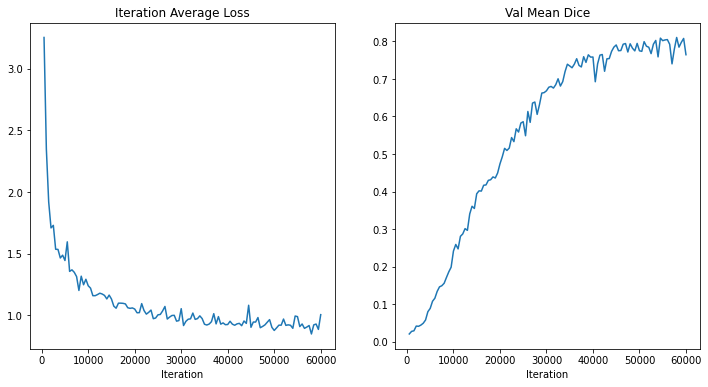

In [19]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Iteration Average Loss")
x = [eval_num * (i + 1) for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [eval_num * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.show()

### Check best model output with the input image and label

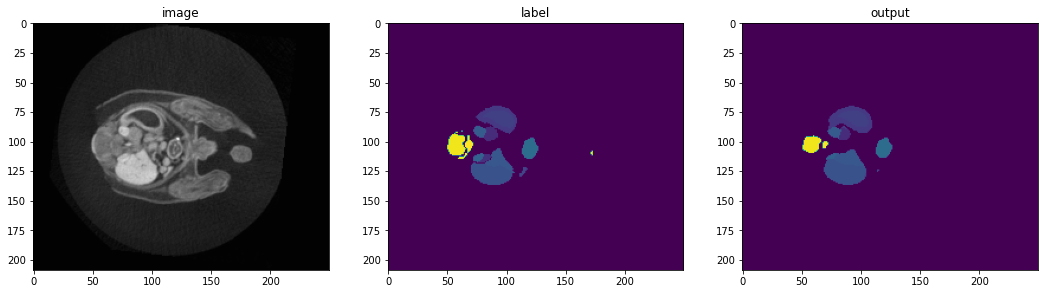

In [10]:
case_num = 5
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))
model.eval()
with torch.no_grad():
    img_name = os.path.split(val_ds[case_num]["image_meta_dict"]["filename_or_obj"])[1]
    img = val_ds[case_num]["image"]
    label = val_ds[case_num]["label"]
    val_inputs = torch.unsqueeze(img, 1).cuda()
    val_labels = torch.unsqueeze(label, 1).cuda()
    val_outputs = sliding_window_inference(
        val_inputs, (96, 96, 96), 4, model, overlap=0.8
    )
    plt.figure("check", (18, 6))
    plt.subplot(1, 3, 1)
    plt.title("image")
    plt.imshow(val_inputs.cpu().numpy()[0, 0, :, :, slice_map[img_name]], cmap="gray")
    plt.subplot(1, 3, 2)
    plt.title("label")
    plt.imshow(val_labels.cpu().numpy()[0, 0, :, :, slice_map[img_name]])
    plt.subplot(1, 3, 3)
    plt.title("output")
    plt.imshow(
        torch.argmax(val_outputs, dim=1).detach().cpu()[0, :, :, slice_map[img_name]]
    )
    plt.show()

### Cleanup data directory

Remove directory if a temporary was used.

In [18]:
if directory is None:
    shutil.rmtree(root_dir)